# Diagnostic plotting & systematic check on the KMeans parameter for the PBMCs
                            
## INPUT: 

 * data/test_data/pbmc.h5ad
 
## OUTPUT: 

 * None, plots within.
 
## Environment Setup

In [3]:
work_dir = '../../' #Path to Cytocipher_manuscript
import os, sys
os.chdir(work_dir)

import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances

import utils.visualisation.helpers as vhs
import utils.visualisation.quick_plots as qpl
qpl.setUp()

import seaborn as sb

import importlib as imp

import cytocipher as cc

data_dir = 'data/test_data/'
data_dir2 = 'data/dev_data/'

## PMC data analysis

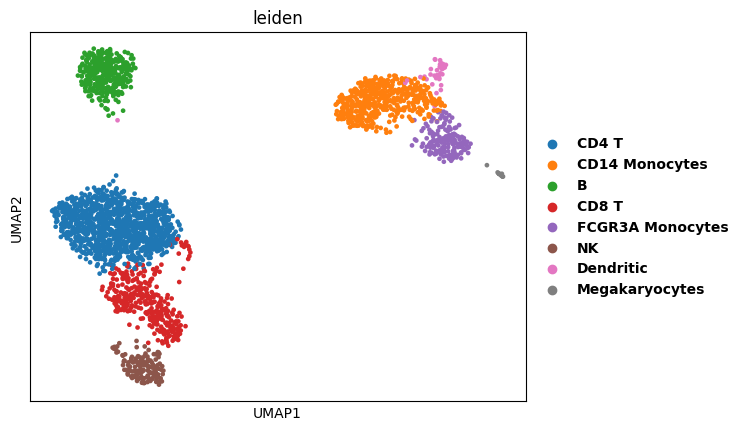

In [2]:
data = sc.read_h5ad(data_dir+'pbmc.h5ad')

sc.pl.umap(data, color='leiden')

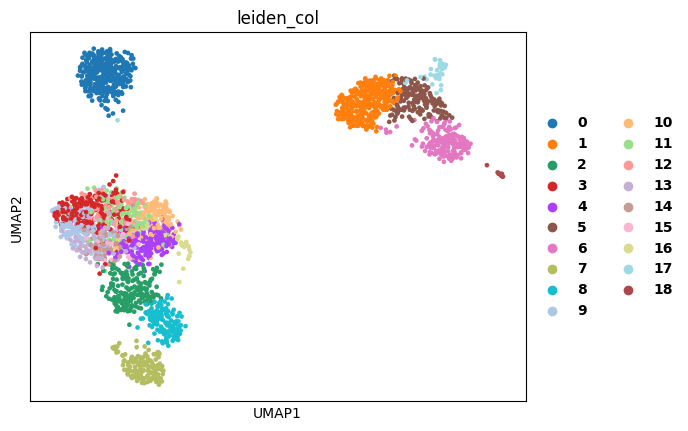

In [3]:
col = 'leiden_col'
sc.tl.leiden(data, resolution=2, key_added=col)
sc.pl.umap(data, color=col)

In [183]:
cc.tl.merge_clusters(data, col, n_cpus=2)

Initial merge.
Added data.obs[f'leiden_col_merged']
Exiting due to reaching max_iter 0


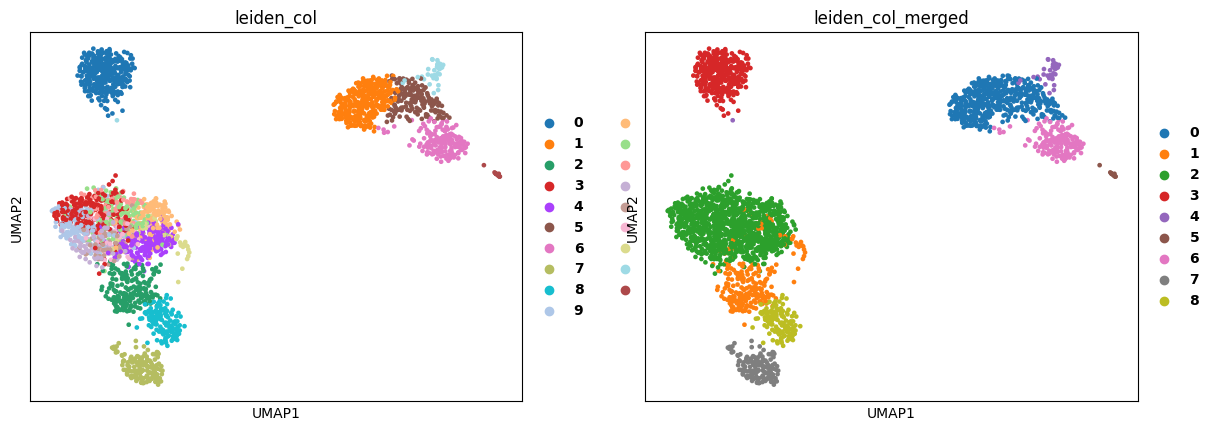

In [117]:
sc.pl.umap(data, color=[col, f'{col}_merged'])

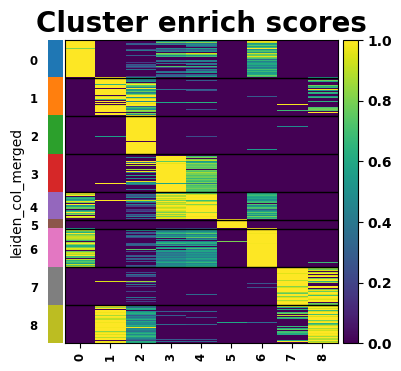

In [118]:
cc.pl.enrich_heatmap(data, f'{col}_merged', figsize=(4,4))

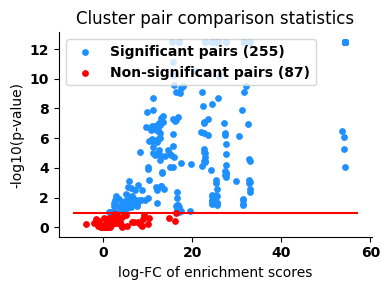

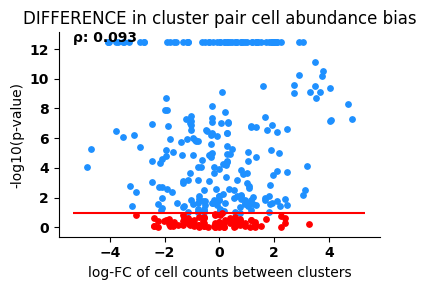

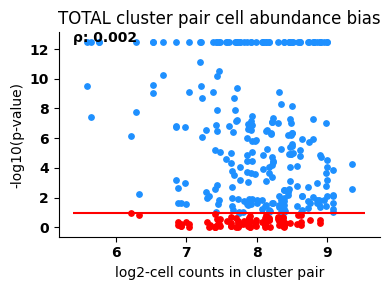

In [187]:
p_size = 15
cc.pl.volcano(data, col, .1, show_legend=True, figsize=(4,3), point_size=p_size, show=True)

cc.pl.check_abundance_bias(data, col, p_cut=.1, show_legend=False, figsize=(4,3), point_size=p_size, show=True)

cc.pl.check_total_abundance_bias(data, col, p_cut=.1, point_size=p_size, 
                           show_legend=False, figsize=(4,3), show=True)

### Looking at cell abundance bias without KMeans

In [9]:
?cc.tl.merge_clusters

In [188]:
cc.tl.merge_clusters(data, col, n_cpus=2, k=None)

Initial merge.
Added data.obs[f'leiden_col_merged']
Exiting due to reaching max_iter 0


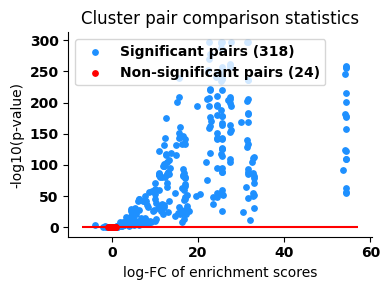

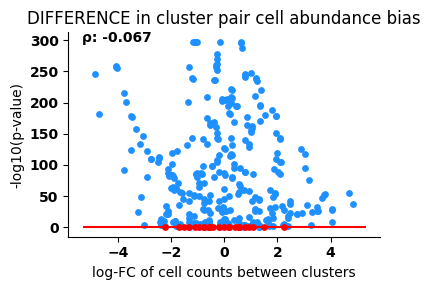

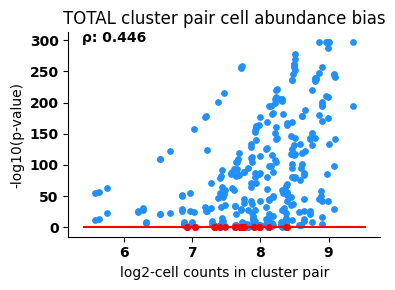

In [189]:
p_size = 15
cc.pl.volcano(data, col, p_cut=.1, show_legend=True, figsize=(4,3), point_size=p_size, show=True)

cc.pl.check_abundance_bias(data, col, p_cut=.1, 
                           show_legend=False, figsize=(4,3), point_size=p_size, show=True)

cc.pl.check_total_abundance_bias(data, col, p_cut=.1, 
                           show_legend=False, figsize=(4,3), point_size=p_size, show=True)

In [143]:
#### What happens if we adjust the p-values?
p_vals = np.array(list(data.uns['leiden_col_ps'].values()))
p_adjs = p_vals*len(p_vals)
p_adjs[p_adjs>1] = 1 

pairs = list(data.uns['leiden_col_ps'].keys())
new_ps = {pairs[i]: p_adjs[i] for i in range(len(pairs))}

data.uns['leiden_col_ps'] = new_ps

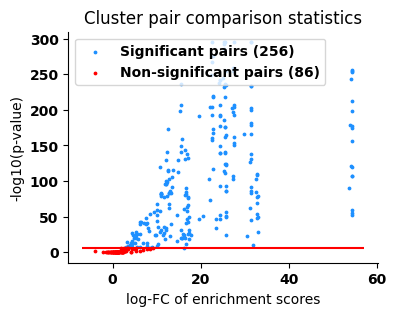

In [144]:
cc.pl.volcano(data, col, p_cut=1e-6, show_legend=True, figsize=(4,3), show=False)

Still over-zealous, but the difference in the number of cells between groups does not appear to effect the significance level. 

However, I suspect the total number of cells in the clusters being compared, will have an effect! Let's check!

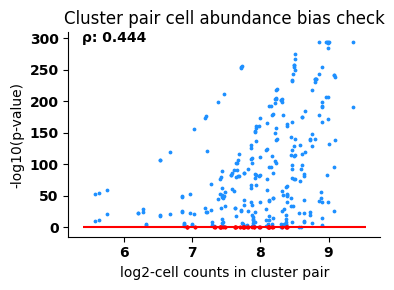

In [145]:
cc.pl.check_total_abundance_bias(data, col, p_cut=.1, 
                           show_legend=False, figsize=(4,3), show=True)

***CLEARLY very heavily biased in significance toward cluster pairs with a greater no. of cells!!!!***

This is not the case when using the k-means clustering above, as we can see clearly almost no bias at all! Fantastic!!!

Let's show this more quantitatively, by re-performing the analysis multiple times & calculating the Spearman correlation of no. of clusters with the KMeans value.

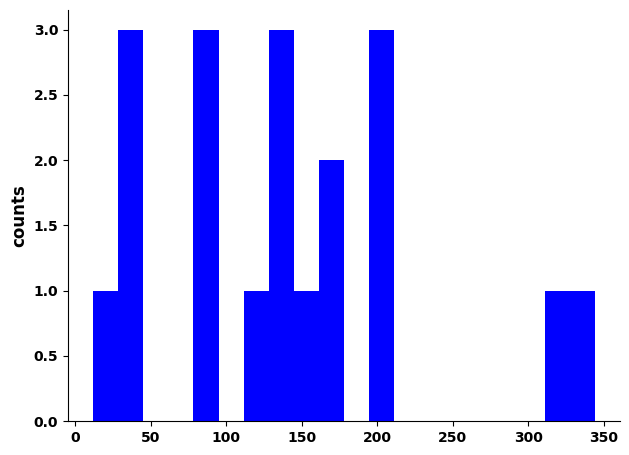

[344 312]
344
656
21
[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 30, 80, 130, 180, 230, 280, 330, None]


In [32]:
## Checking max cluster pair size...
groupby = col
labels = data.obs[groupby].values.astype(str)
label_set = np.unique(labels)

cell_counts = np.array(
    [len(np.where(labels == label)[0]) for label in label_set])
qpl.distrib(cell_counts, bins=20)

order = np.argsort(-cell_counts)
max_size = max(cell_counts)
max_pair_size = sum(cell_counts[order[0:2]])
print(cell_counts[order[0:2]])
print(max_size)
print(max_pair_size)

ks = list(range(5, 30, 2))+list(range(30, max_size, 50))+[None]
print(len(ks))
print(ks)

In [40]:
from scipy.stats import spearmanr

spearmans = []
for i, k in enumerate(ks):
    #### Merging clusters
    print('Current k: ', k)
    cc.tl.merge_clusters(data, col, n_cpus=2, k=k)
    
    #### Gettings the p-value stats
    pvals = np.array(list(data.uns[f'{groupby}_ps'].values()))
    min_sig_nonzero = min(pvals[pvals > 0])
    log10_ps = np.array(
        [-np.log10(pval + sys.float_info.min) for pval in pvals])
    log10_ps[pvals == 0] = -np.log10(min_sig_nonzero)
    pairs = np.array(list(data.uns[f'{groupby}_ps'].keys()))
    pair1s = np.array([pair.split('_')[-1] for pair in pairs])
    pair2s = np.array([pair.split('_')[0] for pair in pairs])

    #### Calculating correlation with total spots in cluster pair.
    log_counts = np.array(
        [np.log2(np.sum([cell_counts[label_set == pair1s[i]][0],
                         cell_counts[label_set == pair2s[i]][0]]))
         for i in range(len(pairs))])
    
    corr = round(spearmanr(log_counts, log10_ps)[0], 3)
    
    spearmans.append(corr)
    
print("DONE!!!!!!")

Current k:  5
Initial merge.
Added data.obs[f'leiden_col_merged']
Exiting due to reaching max_iter 0
Current k:  7
Initial merge.
Added data.obs[f'leiden_col_merged']
Exiting due to reaching max_iter 0
Current k:  9
Initial merge.
Added data.obs[f'leiden_col_merged']
Exiting due to reaching max_iter 0
Current k:  11
Initial merge.
Added data.obs[f'leiden_col_merged']
Exiting due to reaching max_iter 0
Current k:  13
Initial merge.
Added data.obs[f'leiden_col_merged']
Exiting due to reaching max_iter 0
Current k:  15
Initial merge.
Added data.obs[f'leiden_col_merged']
Exiting due to reaching max_iter 0
Current k:  17
Initial merge.
Added data.obs[f'leiden_col_merged']
Exiting due to reaching max_iter 0
Current k:  19
Initial merge.
Added data.obs[f'leiden_col_merged']
Exiting due to reaching max_iter 0
Current k:  21
Initial merge.
Added data.obs[f'leiden_col_merged']
Exiting due to reaching max_iter 0
Current k:  23
Initial merge.
Added data.obs[f'leiden_col_merged']
Exiting due to rea

In [47]:
print(ks)
print(spearmans)

print(spearmans[np.argmin(spearmans)])
print(ks[np.argmin(spearmans)])

[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 30, 80, 130, 180, 230, 280, 330, None]
[0.007, 0.024, 0.032, 0.046, 0.006, 0.002, 0.013, 0.013, 0.013, 0.025, 0.022, 0.03, 0.024, 0.021, 0.063, 0.118, 0.197, 0.313, 0.332, 0.379, 0.446]
0.002
15


How lucky is that!!! Appears the default value of K=15 is the optimum!!!! :')

Text(0, 0.5, 'ρ cell abundance vs. -log10(pval)')

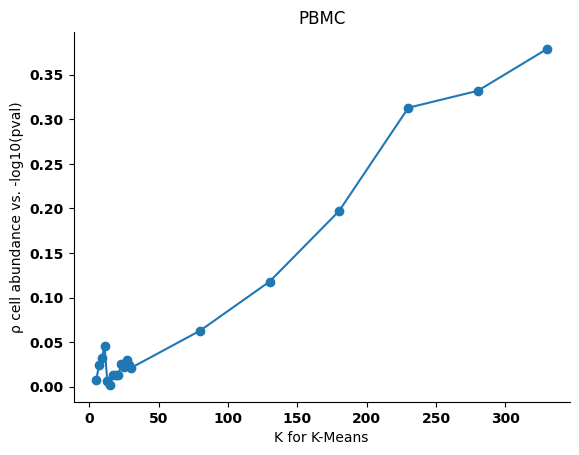

In [54]:
fig, ax = plt.subplots()
ax.scatter(ks[0:len(spearmans)], spearmans)
ax.plot(ks[0:len(spearmans)], spearmans)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title('PBMC')
ax.set_xlabel("K for K-Means")
ax.set_ylabel("ρ cell abundance vs. -log10(pval)")

## Now also looking at the effect of the K-Means on the distribution itself...

In [1210]:
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
import cytocipher.score_and_merge.cluster_merge as cm
import cytocipher.score_and_merge.cluster_score as cs

#### Editing the original merge_clusters function for a single iteration so that it returns the K-Means values
#### for plotting purposes!!!
def merge_clusters_single(data: sc.AnnData, groupby: str, key_added: str,
                          k: int = 15, knn: int = None, random_state=20,
                          p_cut: float=.1, verbose: bool = True):
    """ Gets pairs of clusters which are not significantly different from one
        another based on the enrichment score.
    """
    ### Extracting required information ###
    labels = data.obs[groupby].values
    enrich_scores = data.obsm[f'{groupby}_enrich_scores']
    label_set = enrich_scores.columns.values
    label_scores = [enrich_scores.values[:, i] for i in range(len(label_set))]

    ### Averaging data to get nearest neighbours ###
    neighbours = []
    dists = []
    if type(knn)!=type(None) and knn < (len(label_set)-1):
        if verbose:
            print("Getting nearest neighbours by enrichment scores.")

        avg_data = average(enrich_scores, labels, label_set)
        point_tree = spatial.cKDTree(avg_data)
        for i, labeli in enumerate(label_set):
            nearest_info = point_tree.query(avg_data[i, :], k=knn + 1)
            nearest_indexes = nearest_info[1]
            dists_ = nearest_info[0]

            neighbours.append([label_set[index] for index in nearest_indexes
                               if label_set[index]!=labeli])
            dists.append( [dist for i_, dist in enumerate(dists_)
                           if label_set[nearest_indexes[i_]]!=labeli] )
    else:
        for label in label_set:
            neighbours.append( list(label_set[label_set!=label]) )
            dists.append( [np.nan]*(len(label_set)-1) )

    data.uns[f'{groupby}_neighbours'] = {label: neighbours[i]
                                         for i, label in enumerate(label_set)}
    data.uns[f'{groupby}_neighdists'] = {label: dists[i]
                                         for i, label in enumerate(label_set)}

    # Now going through the MNNs and testing if their cross-scores are significantly different
    if verbose:
        print(
            "Getting pairs of clusters where atleast in one direction not significantly different from one another.")

    kmeans = KMeans(n_clusters=k, random_state=random_state)

    pairs = []
    ps_dict = {}
    k_values = {}
    bin_values = {}
    q_values = {}
    values = {}
    for i, labeli in enumerate(label_set):
        for j, labelj in enumerate(label_set):
            if labelj in neighbours[i] and labeli in neighbours[j]:

                labeli_labelj_scores = label_scores[j][labels == labeli]
                labelj_labelj_scores = label_scores[j][labels == labelj]

                ### Account for n cells <= k
                if type(k)!=type(None) and len(labeli_labelj_scores) > k:
                    groupsi = kmeans.fit_predict(
                        labeli_labelj_scores.reshape(-1, 1))
                    labeli_labelj_scores_mean = \
                        [np.mean(labeli_labelj_scores[groupsi == k]) for k in
                         np.unique(groupsi)]
                    
                    #### Trying a binning strategy
                    order = np.argsort( labeli_labelj_scores )
                    scores_ordered = labeli_labelj_scores[ order ]
                    #print(scores_ordered)
                    interval = len(labeli_labelj_scores)//k
                    print(f'{labeli}_{labelj}', len(scores_ordered), interval, k)
                    start = 0
                    labeli_labelj_scores_binned = []
                    for end in range(interval, len(scores_ordered), interval):
                        vals__ = scores_ordered[start:end]
                        #print(start, end)
                        #print(vals__, '\n\n')
                        labeli_labelj_scores_binned.append( np.mean(vals__) )
                        start = end
                    if end < len(scores_ordered):
                        #print(end, 'onward')
                        #print(scores_ordered[end:], '\n\n')
                        labeli_labelj_scores_binned.append( np.mean(scores_ordered[end:]) )
                    
                    ### Trying quantile strategy
                    q = np.array([(1/k)*i for i in range(1,k+1)])
                    labeli_labelj_quantiles = np.quantile(scores_ordered, q=q,
                                                          method='nearest')
                    
                else:
                    labeli_labelj_scores_mean = labeli_labelj_scores
                    labeli_labelj_scores_binned = labeli_labelj_scores
                    labeli_labelj_quantiles = labeli_labelj_scores

                if type(k)!=type(None) and len(labelj_labelj_scores) > k:
                    groupsj = kmeans.fit_predict(
                        labelj_labelj_scores.reshape(-1, 1))
                    labelj_labelj_scores_mean = \
                        [np.mean(labelj_labelj_scores[groupsj == k]) for k in
                         np.unique(groupsj)]
                    
                    #### Trying a binning strategy
                    order = np.argsort( labelj_labelj_scores )
                    scores_ordered = labelj_labelj_scores[ order ]
                    #print(scores_ordered)
                    interval = len(labelj_labelj_scores)//k
                    start = 0
                    labelj_labelj_scores_binned = []
                    for end in range(interval, len(scores_ordered), interval):
                        vals__ = scores_ordered[start:end]
                        #print(start, end)
                        #print(vals__, '\n\n')
                        labelj_labelj_scores_binned.append( np.mean(vals__) )
                        start = end
                    if end < len(scores_ordered):
                        #print(end, 'onward')
                        #print(scores_ordered[end:], '\n\n')
                        labelj_labelj_scores_binned.append( np.mean(scores_ordered[end:]) )
                        
                    ### Trying quantile strategy
                    q = np.array([(1/k)*i for i in range(1,k+1)])
                    labelj_labelj_quantiles = np.quantile(scores_ordered, q=q,
                                                          method='nearest')
                    
                else:
                    labelj_labelj_scores_mean = labelj_labelj_scores
                    labelj_labelj_scores_binned = labelj_labelj_scores
                    labelj_labelj_quantiles = labelj_labelj_scores

                print(len(labeli_labelj_scores), len(labeli_labelj_scores_mean), 
                      len(labeli_labelj_scores_binned), len(labeli_labelj_quantiles))
                    
                t, p = ttest_ind(labeli_labelj_scores_mean,
                                 labelj_labelj_scores_mean)
                #### Above outputs nan if all 0's for one-case, indicate significant difference
                if np.isnan(p) and (
                        np.all(np.array(labeli_labelj_scores_mean) == 0) or
                        np.all(np.array(labelj_labelj_scores_mean) == 0)):

                    p = 0

                ps_dict[f'{labeli}_{labelj}'] = p
                k_values[f'{labeli}_{labelj}'] = [labeli_labelj_scores_mean,
                                                  labelj_labelj_scores_mean]
                bin_values[f'{labeli}_{labelj}'] = [labeli_labelj_scores_binned,
                                                    labelj_labelj_scores_binned]
                q_values[f'{labeli}_{labelj}'] = [labeli_labelj_quantiles,
                                                    labelj_labelj_quantiles]
                values[f'{labeli}_{labelj}'] = [labeli_labelj_scores,
                                                labelj_labelj_scores]
                
                if p > p_cut:
                    pairs.append((labeli, labelj))

    # Now identifying pairs which are mutually not-significant from one another;
    # i.e. cluster 1 is not signicant from cluster 2, and cluster 2 not significant from cluster 1.
    if verbose:
        print(
            "Getting pairs of clusters which are mutually not different from one another.")

    mutual_pairs = []
    for pairi in pairs:
        for pairj in pairs:
            if pairi[0] == pairj[1] and pairi[1] == pairj[0] \
                    and pairi not in mutual_pairs and pairj not in mutual_pairs:
                mutual_pairs.append(pairi)

    data.uns[f'{groupby}_mutualpairs'] = mutual_pairs
    data.uns[f'{groupby}_ps'] = ps_dict
    data.uns[f'{groupby}_kvalues'] = k_values
    data.uns[f'{groupby}_binvalues'] = bin_values
    data.uns[f'{groupby}_qvalues'] = q_values
    data.uns[f'{groupby}_values'] = values
    if verbose:
        print(f"Added data.uns['{groupby}_mutualpairs']")
        print(f"Added data.uns['{groupby}_ps']")
        print(f"Added data.uns['{groupby}_neighbours']")
        print(f"Added data.uns['{groupby}_neighdists']")

    # Now merging the non-signficant clusters #
    cluster_map, merge_cluster_labels = cm.merge_neighbours_v2(labels,
                                                               mutual_pairs, )
    data.obs[key_added] = merge_cluster_labels
    data.obs[key_added] = data.obs[key_added].astype('category')
    data.obs[key_added] = data.obs[key_added].cat.set_categories(
        np.unique(merge_cluster_labels.astype(int)).astype(str))

    if verbose:
        print(f"Added data.obs['{key_added}']")
        
def merge_clusters(data: sc.AnnData, groupby: str,
                   var_groups: str=None, n_top_genes: int = 6, t_cutoff: int=3,
                   marker_padj_cutoff: float=.05,
                   enrich_method: str = 'code', p_cut: float=.1,
                   max_iter: int = 0, knn: int = None,
                   k: int = 15, random_state=20,
                   n_cpus: int = 1,
                   verbose: bool = True):
    """ Merges the clusters following an expectation maximisation approach.

    Parameters
    ----------
    data: sc.AnnData
        Single cell RNA-seq anndata, QC'd a preprocessed to log-cpm in data.X
    groupby: str
        Specifies the clusters to merge, defined in data.obs[groupby]. Must
        be categorical type.
    var_groups: str
        Specifies a column in data.var of type boolean, with True indicating
        the candidate genes to use when determining marker genes per cluster.
        Useful to, for example, remove ribosomal and mitochondrial genes.
        None indicates use all genes in data.var_names as candidates.
    n_top_genes: int
        The maximimum no. of marker genes per cluster.
    t_cutoff: float
        The minimum t-value a gene must have to be considered a marker gene
        (Welch's t-statistic with one-versus-rest comparison).
    marker_padj_cutoff: float
        Adjusted p-value (Benjamini-Hochberg correction) below which a gene
        can be considered a marker gene.
    enrich_method: str
        Enrichment method to use for scoring cluster membership.
        Must be one of 'code', 'coexpr', or 'giotto'.
    p_cut: float
        P-value cutoff for merging clusters. Cluster pairs above this value are
        considered non-significant and thus merged.
    max_iter: int
        Maximum number of iterations of the expectation-maximisation to perform,
        returns solution at this number of iterations or when convergence
        achieved.
    knn: int
        Number of nearest-neighbours for each cluster to determine, after
        which mutual nearest neighbour clusters are compared. Default None
        indicates to perform pair-wise comparison between clusters.
    k: int
        k for the k-means clustering of the enrichment scores prior to
        significance testing, to reduce group imbalance bias and inflated
        statistical power due to pseudoreplication.
        Set to None to use each cell as an observation.
    random_state: int
        Random seed for the k-means clustering. Set by default to ensure
        reproducibility each time function run with same data & input params.
    n_cpus: int
        Number of cpus to perform for the computation.
    verbose: bool
        Print statements during computation (True) or silent run (False).
    Returns
    --------
        data.obs[f'{groupby}_merged']
            New cell type labels with non-sigificant clusters merged.
        data.uns[f'{groupby}_merged_markers']
            Dictionary with merged cluster names as keys, and list of marker
            genes as values.
        data.obsm[f'{groupby}_merged_enrich_scores']
            Dataframe with cells as rows and merged clusters as columns.
            Values are the enrichment scores for each cluster, using the
            marker genes in data.uns[f'{groupby}_merged_markers']
    """

    ### Initial merge ##
    if verbose:
        print("Initial merge.")

    cs.get_markers(data, groupby, n_top=n_top_genes, verbose=False,
                var_groups=var_groups, t_cutoff=t_cutoff,
                padj_cutoff=marker_padj_cutoff,)
    cm.run_enrich(data, groupby, enrich_method, n_cpus)

    old_labels = data.obs[groupby].values.astype(str)
    
    ### NOTE: without the cm. prefix, will use the modified function version above.
    merge_clusters_single(data, groupby, f'{groupby}_merged',
                          k=k, knn=knn, random_state=random_state,
                          p_cut=p_cut, verbose=False)

    ## Reached max iter, exit with current solution ##
    # Running marker gene determination #
    cs.get_markers(data, f'{groupby}_merged', n_top=n_top_genes, verbose=False,
                var_groups=var_groups, t_cutoff=t_cutoff,
                padj_cutoff=marker_padj_cutoff,)

    # Running the enrichment scoring #
    cm.run_enrich(data, f'{groupby}_merged', enrich_method, n_cpus)

    if verbose:
        print(f"Added data.obs['{groupby}_merged']")
        print(f"Exiting due to reaching max_iter {max_iter}")

def violin(scores, ax, colors_, colors_2, pair1, pair2, groupby):
    """ Plots a violin on the given ax.
    """
    scores_by_cluster = np.array(scores, dtype='object').transpose()
    sb.stripplot(data=scores_by_cluster, ax=ax, palette=colors_,
                 edgecolor='k', linewidth=1)
    sb.violinplot(data=scores_by_cluster, inner=None, color='.8', ax=ax,
                  palette=colors_2)
    ax.set_xticklabels([f'{pair1} cells; {pair2} scores',
                        f'{pair2} cells; {pair2} scores',
                        ],
                       rotation=40
                       )
    ax.set_xlabel(groupby)
    ax.set_ylabel("Cluster enrich scores")
    # Removing boxes outside #
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
def compare_kdistribs(data, groupby, pair, show=True):
    """Compares the enrichment distributions before and after the KMeans clustering...
    """
    pair1, pair2 = pair.split('_')
    scores = data.uns[f'{groupby}_kvalues'][pair]

    labels = data.obs[groupby].values
    enrich_scores = data.obsm[f'{groupby}_enrich_scores']
    label_set = enrich_scores.columns.values
    label_scores = [enrich_scores.values[:, i] for i in range(len(label_set))]
    colors = {name: data.uns[f'{groupby}_colors'][i] for i, name in \
                                    enumerate(data.obs[groupby].cat.categories)}

    colors_ = [ colors[pair1], colors[pair2] ]
    colors_2 = [ colors[pair2], colors[pair2] ] 

    fig, axes = plt.subplots(figsize=(12, 3), ncols=4)
    ax1 = axes[1]
    ax1.set_title("K-Means")
    violin(scores, ax1, colors_, colors_2, pair1, pair2, groupby)

    #### Now plotting the original scores
    i, labeli = np.where(label_set == pair1)[0][0], pair1
    j, labelj = np.where(label_set == pair2)[0][0], pair2

    labeli_labelj_scores = label_scores[j][labels == labeli]
    labelj_labelj_scores = label_scores[j][labels == labelj]

    scores = [labeli_labelj_scores, labelj_labelj_scores]

    

    ax = axes[0]
    ax.set_title("Original")
    violin(scores, ax, colors_, colors_2, pair1, pair2, groupby)
    ax1.set_ylim(ax.get_ylim())
    
    #### Now plotting the binned scores...
    ax2 = axes[2]
    ax2.set_title("K-Bin means")
    scores = data.uns[f'{groupby}_binvalues'][pair]
    violin(scores, ax2, colors_, colors_2, pair1, pair2, groupby)
    ax2.set_ylim(ax.get_ylim())
    
    #### Now plotting the quantile scores...
    ax3 = axes[3]
    ax3.set_title("K-Quantiles")
    scores = data.uns[f'{groupby}_qvalues'][pair]
    violin(scores, ax3, colors_, colors_2, pair1, pair2, groupby)
    ax3.set_ylim(ax.get_ylim())
    
    if show:
        plt.show()

In [1211]:
merge_clusters(data, col, n_cpus=2)

Initial merge.
0_1 344 22 15
344 3 16 15
0_2 344 22 15
344 4 16 15
0_3 344 22 15
344 15 16 15
0_4 344 22 15
344 15 16 15
0_5 344 22 15
344 10 16 15
0_6 344 22 15
344 2 16 15
0_7 344 22 15
344 1 16 15
0_8 344 22 15
344 1 16 15
0_9 344 22 15
344 15 16 15
0_10 344 22 15
344 15 16 15
0_11 344 22 15
344 15 16 15
0_12 344 22 15
344 15 16 15
0_13 344 22 15
344 15 16 15
0_14 344 22 15
344 15 16 15
0_15 344 22 15
344 15 16 15
0_16 344 22 15
344 10 16 15
0_17 344 22 15
344 15 16 15
0_18 344 22 15
344 2 16 15
1_0 312 20 15
312 15 16 15
1_2 312 20 15
312 1 16 15
1_3 312 20 15
312 15 16 15
1_4 312 20 15
312 15 16 15
1_5 312 20 15
312 15 16 15
1_6 312 20 15
312 15 16 15
1_7 312 20 15
312 2 16 15
1_8 312 20 15
312 1 16 15
1_9 312 20 15
312 15 16 15
1_10 312 20 15
312 14 16 15
1_11 312 20 15
312 15 16 15
1_12 312 20 15
312 15 16 15
1_13 312 20 15
312 15 16 15
1_14 312 20 15
312 15 16 15
1_15 312 20 15
312 15 16 15
1_16 312 20 15
312 8 16 15
1_17 312 20 15
312 15 16 15
1_18 312 20 15
312 4 16 15
2_0 20

17_9 36 2 15
36 15 18 15
17_10 36 2 15
36 8 18 15
17_11 36 2 15
36 15 18 15
17_12 36 2 15
36 15 18 15
17_13 36 2 15
36 15 18 15
17_14 36 2 15
36 15 18 15
17_15 36 2 15
36 15 18 15
17_16 36 2 15
36 2 18 15
17_18 36 2 15
36 1 18 15
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
Added data.obs['leiden_col_merged']
Exiting due to reaching max_iter 0


In [1212]:
##### For each pair, calculate the p-value with the different methods...
methods = ['values', 'kvalues', 'binvalues', 'qvalues']
pairs = list( data.uns['leiden_col_ps'].keys() )
method_ps = [{} for method in methods]

for i, method in enumerate(methods):
    for pair in pairs:
        t, p = ttest_ind(data.uns[f'leiden_col_{method}'][pair][0], 
                         data.uns[f'leiden_col_{method}'][pair][1])
        p = p if not np.isnan(p) else 0

        method_ps[i][pair] = p
        
    data.uns[f'leiden_col_{method}_ps'] = method_ps[i]

In [1213]:
#### Editing check for total abundance such that can check different p-values above
import matplotlib
def check_total_abundance_bias(data: sc.AnnData, groupby: str, method: str, #EDIT
                               p_cut: float=None,
                         show_legend: bool=True, legend_loc: str='best',
                         figsize: tuple=(6,4), point_size: int=3,
                         ax: matplotlib.axes.Axes=None, show: bool=True):
    """ Checks for bias between pair significance and the TOTAL number of cells
        in the pair of clusters being compared.
        Different from cc.pl.check_abundance_bias in that this does not check
        for bias due to imbalanced groups, but rather the total number of cells
        considered as observations.
        Spearman correlation displayed.
        Should be no bias, i.e. correlation close to 0.

        Parameters
        ----------
        data: AnnData
            Single cell data on which cc.tl.merge_clusters has been performed.
        groupby: str
            Column in data.obs specifying pre-merged clusters input
                                                        to cc.tl.merge_clusters.
        p_cut: float
           P-value used as cutoff to determine significantly different clusters.
           If None then just shows the relationship without highlighting the
           significant versus non-significant cluster pairs.
        show_legend: bool
            Whether to show the legend that highlights significant versus non-
            significant cluster pairs.
        show: bool
            Whether to show the plot.
    """

    labels = data.obs[groupby].values.astype(str)
    label_set = np.unique(labels)

    cell_counts = np.array(
        [len(np.where(labels == label)[0]) for label in label_set])

    #### Getting the pairs which were compared
    pvals = np.array(list(data.uns[f'{groupby}_{method}_ps'].values()))
    min_sig_nonzero = min(pvals[pvals > 0])
    log10_ps = np.array(
        [-np.log10(pval + sys.float_info.min) for pval in pvals])
    log10_ps[pvals == 0] = -np.log10(min_sig_nonzero)
    pairs = np.array(list(data.uns[f'{groupby}_{method}_ps'].keys()))
    pair1s = np.array([pair.split('_')[-1] for pair in pairs])
    pair2s = np.array([pair.split('_')[0] for pair in pairs])

    ### Calculating log-FCs for pairs tested.
    log_counts = np.array(
        [np.log2(np.sum([cell_counts[label_set == pair1s[i]][0],
                         cell_counts[label_set == pair2s[i]][0]]))
         for i in range(len(pairs))])

    corr = round(spearmanr(log_counts, log10_ps)[0], 3)

    if type(ax)==type(None):
        fig, ax = plt.subplots(figsize=figsize)
        
    if type(p_cut) != type(None):
        sig_bool = pvals < p_cut
        nonsig_bool = pvals >= p_cut

        ax.scatter(log_counts[sig_bool], log10_ps[sig_bool], s=point_size,
                   c='dodgerblue')
        ax.scatter(log_counts[nonsig_bool], log10_ps[nonsig_bool],
                   s=point_size, c='red')
        ax.hlines(-np.log10(p_cut), ax.get_xlim()[0], ax.get_xlim()[1],
                                                                   colors='red')

        legend = [f'Significant pairs ({sum(sig_bool)})',
                  f'Non-significant pairs ({sum(nonsig_bool)})']

    else:
        ax.scatter(log_counts, log10_ps, s=point_size, c='orchid')

        legend = [f'Cluster pairs ({len(log_counts)})']

    ax.set_xlabel("log2-cell counts in cluster pair")
    ax.set_ylabel("-log10(p-value)")
    ax.set_title("TOTAL cluster pair cell abundance bias")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if show_legend:
        ax.legend(legend, loc=legend_loc)

    ax.text((ax.get_xlim()[0] + np.min(log_counts)) / 2, np.max(log10_ps),
            f'ρ: {corr}', c='k')

    if show:
        plt.show()

In [1214]:
imp.reload(qpl)

<module 'beautifulcells.visualisation.quick_plots' from '/Users/uqbbalde/Desktop/Uni_Studies/myPython/BeautifulCells/beautifulcells/visualisation/quick_plots.py'>

values
kvalues
binvalues
qvalues


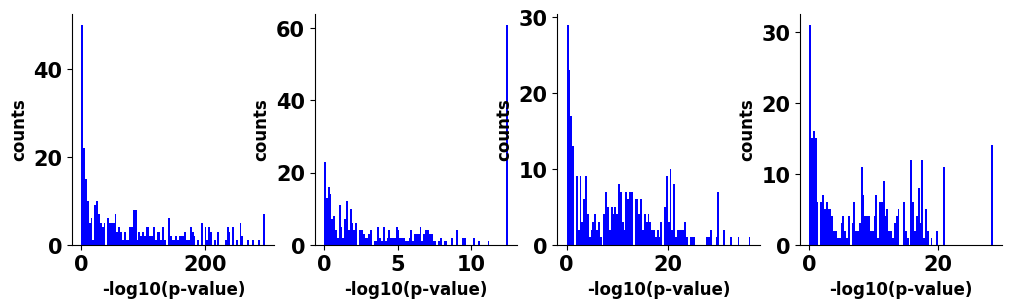

In [1215]:
fig, axes = plt.subplots(figsize=(12,3), ncols=4)
axes = axes.ravel()
for i, method in enumerate(methods):
    ps = np.array( list(data.uns[f'leiden_col_{method}_ps'].values() ) )
    log10ps = -np.log10(ps)
    log10ps[ps==0] = -np.log10(min(ps[ps>0])) 
    qpl.distrib(log10ps, figsize=(3,3), ax=axes[i], fig=fig, show=False,
                x_label='-log10(p-value)')
    ax.set_title(method)
    print(method)

In [1216]:
matplotlib.rcParams['font.size']=15

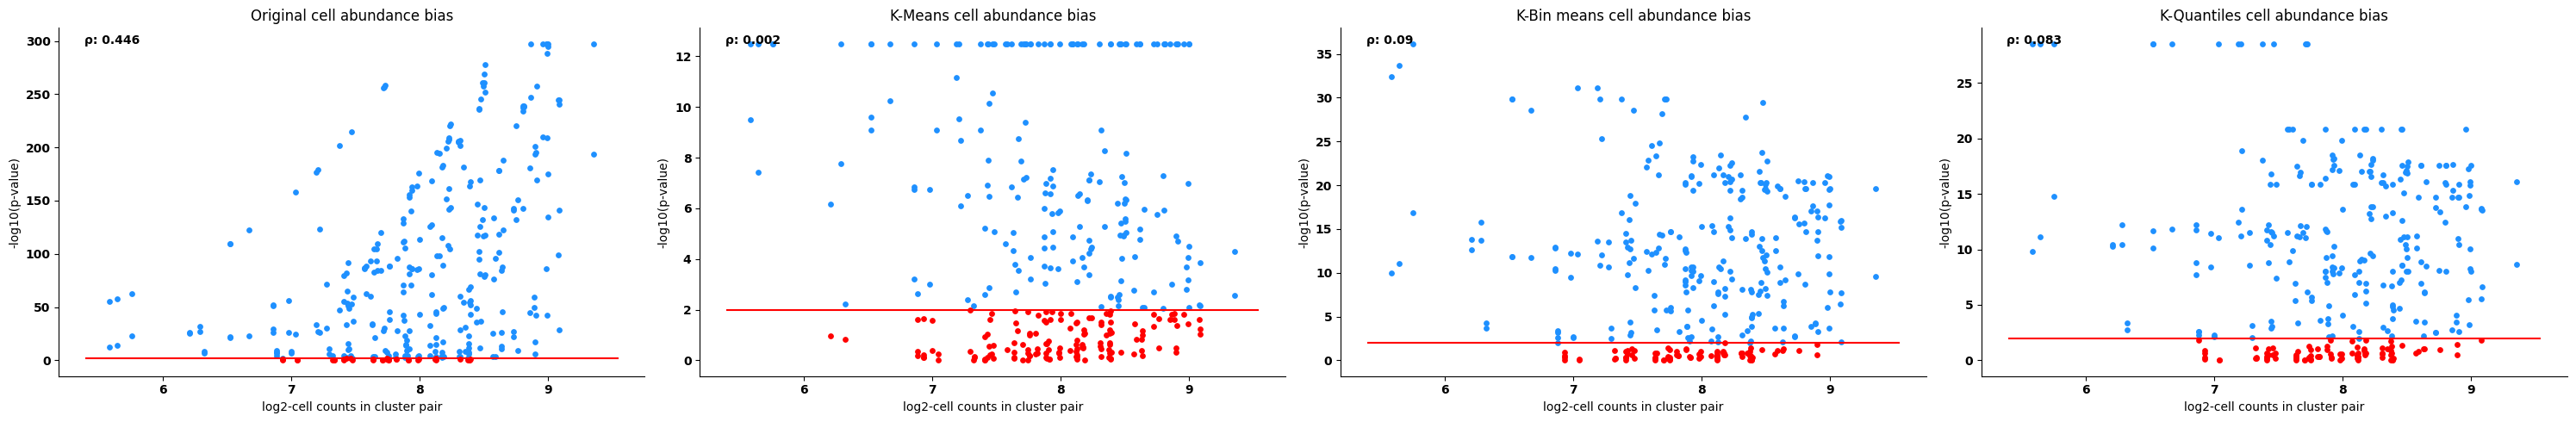

In [1247]:
fig, axes = plt.subplots(figsize=(30, 5), ncols=4)
axes = axes.ravel()
method_names = ['Original', 'K-Means', 'K-Bin means', 'K-Quantiles']
for i, method in enumerate(methods):
    ax = axes[i]
    check_total_abundance_bias(data, 'leiden_col', method, p_cut=1e-2, ax=ax, show_legend=False, show=False,
                              point_size=15)
    ax.set_title(f"{method_names[i]} cell abundance bias")
plt.show()
matplotlib.rcParams['font.size']=10

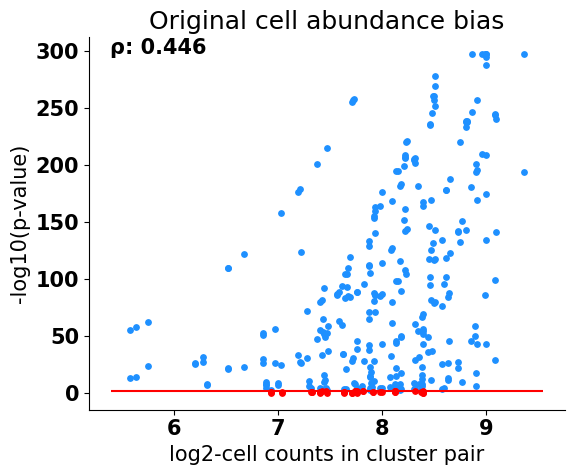

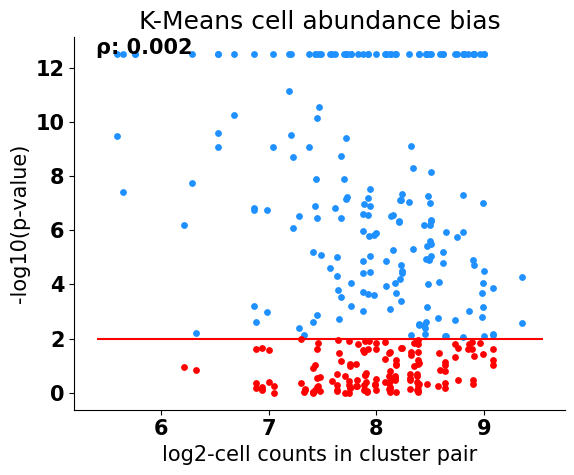

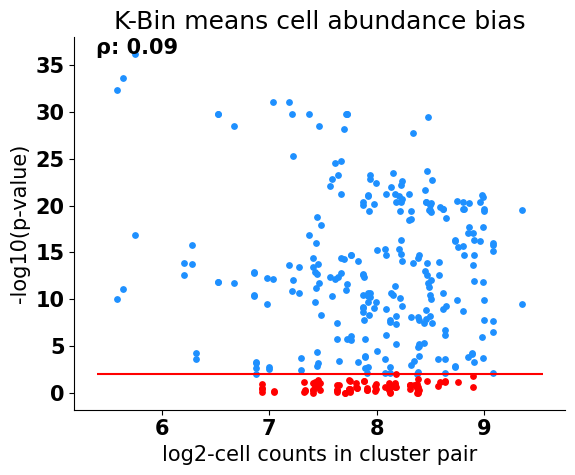

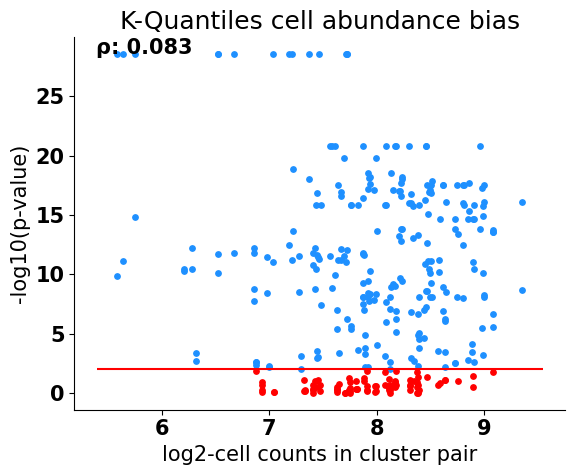

In [1251]:
matplotlib.rcParams['font.size']=15
for i, method in enumerate(methods):
    fig, ax = plt.subplots(figsize=(6, 5))
    check_total_abundance_bias(data, 'leiden_col', method, p_cut=1e-2, ax=ax, show_legend=False, show=False,
                              point_size=15)
    ax.set_title(f"{method_names[i]} cell abundance bias")
    plt.show()
matplotlib.rcParams['font.size']=10

## Observations..

So all of the methods appear to have some accuracy in reducing the bias, however K-Means appears to be the best at this. It does produce the hightest p-values; but by the same token it also results in many cases where p==0, which is quite strange. I wonder what is happening in these cases?

From examining the below, this behaviour is completely reasonable, since it occurs in cases where one of the clusters has ALL 0's, resulting in only one cluster with the K-means strategy, causing the t-test to return nan, which I handle by setting p=0. So this is OK behaviour :) 

In [1218]:
pairs = np.array(list(data.uns['leiden_col_kvalues_ps'].keys()))
kps = np.array(list(data.uns['leiden_col_kvalues_ps'].values()))

pair = '0_5'#pairs[kps==0][1]
#pair = '0_8'
print(data.uns['leiden_col_kvalues'][pair][0])
print(data.uns['leiden_col_binvalues'][pair][0])
print(data.uns['leiden_col_qvalues'][pair][0])

print( ttest_ind(data.uns['leiden_col_values'][pair][0], data.uns['leiden_col_values'][pair][1])[1] )
print( ttest_ind(data.uns['leiden_col_kvalues'][pair][0], data.uns['leiden_col_kvalues'][pair][1])[1] )
print( ttest_ind(data.uns['leiden_col_binvalues'][pair][0], data.uns['leiden_col_binvalues'][pair][1])[1] )
print( ttest_ind(data.uns['leiden_col_qvalues'][pair][0], data.uns['leiden_col_qvalues'][pair][1])[1] )

[0.0, 11.224832002528553, 12.615034941073363, 9.381387281516629, 15.470996016996189, 11.993656107637664, 9.884488264512004, 8.964872137248399, 12.811187481980834, 9.210361689327776]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.254058280201529]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         15.47099602]
0.0
1.0180570303196635e-07
1.0767946794363239e-21
1.2656088229205627e-15


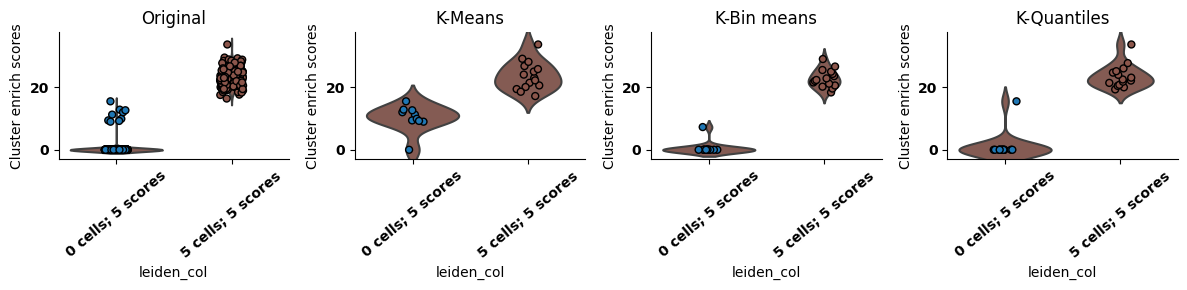

In [1219]:
pair = '0_5'
compare_kdistribs(data, 'leiden_col', pair, show=False)
plt.show()

So far K-Mean appears to be the best in-terms of reducing bias. 

How does it distort the distributions? Let's measure this against the original data for each one of the methods.

In [1220]:
means_orig = []
means_q = []
for pair in pairs:
    means_orig.append( np.mean( data.uns[f'leiden_col_values'][pair][1] ) )
    means_q.append( np.mean( data.uns[f'leiden_col_qvalues'][pair][1] ) )
print(max(means_q), max(means_orig))

q = np.array([(1 / k) * i for i in range(1, k + 1)])
max_index = np.argmax(means_orig)
print(means_orig[max_index], means_q[max_index])

quants = np.quantile(data.uns[f'leiden_col_values'][pairs[max_index]][1], q=q)
np.mean(quants)

print(pairs[max_index])
print( data.uns[f'leiden_col_qvalues'][pairs[max_index]][0] )
print( data.uns[f'leiden_col_values'][pairs[max_index]][1] )

54.30653412793308 54.30653412793308
54.30653412793308 54.30653412793308
0_18
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         36.93542593]
[53.16900528 45.88198667 53.47712758 56.02709466 55.86157676 52.79530354
 55.36165036 57.53554426 52.05566381 58.25473516 54.43367058 56.82505088]


In [1221]:
from scipy.special import kl_div

method_names = ['Original', 'K-Means', 'K-Bin means', 'K-Quantiles']
pairs = np.array(list(data.uns[f'leiden_col_values'].keys()))

method_log10_ps = []
for i_, method in enumerate(methods):
    pairs_ = np.array(list(data.uns[f'leiden_col_{method}_ps'].keys()))
    pvals = np.array(list(data.uns[f'leiden_col_{method}_ps'].values()))
    min_sig_nonzero = min(pvals[pvals > 0])
    log10_ps = np.array([-np.log10(pval + sys.float_info.min)
                                                             for pval in pvals])
    log10_ps[pvals == 0] = -np.log10(min_sig_nonzero)
    log10_ps = {pairs_[j]: log10_ps[j] for j in range(len(pairs_))}
    method_log10_ps.append( log10_ps )
    
results = pd.DataFrame(index=list(range(len(pairs)*len(methods))), columns=['pair', 'method', 'mean', 
                                                                            'std', 'log2_n_cells',
                                                                           '-log10(pval)'])
i = 0
for pair in pairs:
    for i_, method in enumerate(methods):
        vals = data.uns[f'leiden_col_{method}'][pair][1]
        mean_ = np.mean( vals )
        std_ = np.std( vals )
        n_cells = np.log2( len(data.uns[f'leiden_col_values'][pair][1]) )
        
        results.iloc[i,:] = [pair, method_names[i_], mean_, std_, n_cells, method_log10_ps[i_][pair]]
        
        i+=1
    
results

,pair,method,mean,std,log2_n_cells,-log10(pval)
0,0_1,Original,25.463255,4.334044,8.285402,297.459017
1,0_1,K-Means,24.644067,8.519185,8.285402,2.572222
2,0_1,K-Bin means,25.714705,4.415075,8.285402,19.579277
3,0_1,K-Quantiles,26.351426,4.864498,8.285402,16.069466
4,0_2,Original,17.081731,8.754818,7.643856,141.081279
...,...,...,...,...,...,...
1363,18_16,K-Quantiles,17.620323,4.895681,5.247928,11.141514
1364,18_17,Original,32.996208,10.447659,5.169925,12.691183
1365,18_17,K-Means,33.652795,10.477335,5.169925,9.494738
1366,18_17,K-Bin means,32.996208,10.413038,5.169925,9.975379


In [1222]:
results['pair'] = results['pair'].astype(str)
results['method'] = results['method'].astype(str)
results['mean'] = results['mean'].astype(float)
results['std'] = results['std'].astype(float)
results['log2_n_cells'] = results['log2_n_cells'].astype(float)
results['-log10(pval)'] = results['-log10(pval)'].astype(float)

In [1223]:
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

[Text(5.0, 0, '5'),
 Text(6.0, 0, '6'),
 Text(7.0, 0, '7'),
 Text(8.0, 0, '8'),
 Text(9.0, 0, '9'),
 Text(10.0, 0, '10')]

In [1270]:
?sb.violinplot

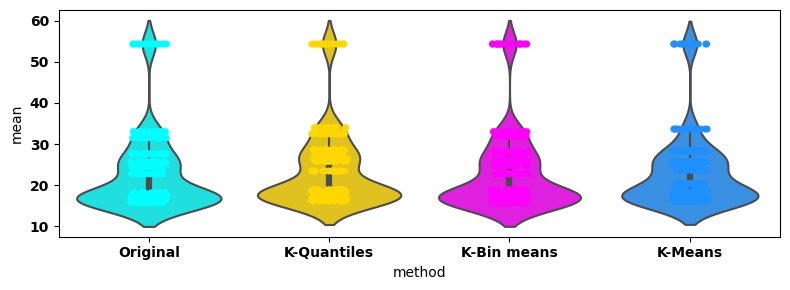

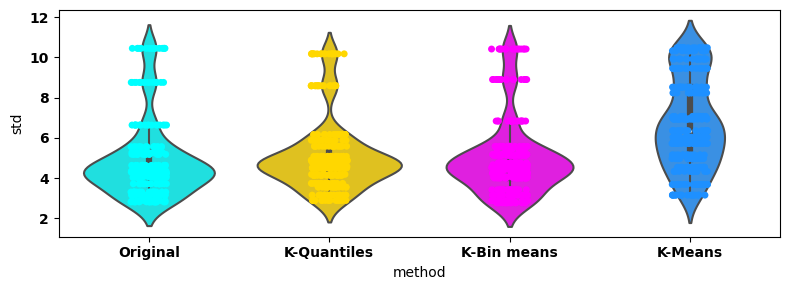

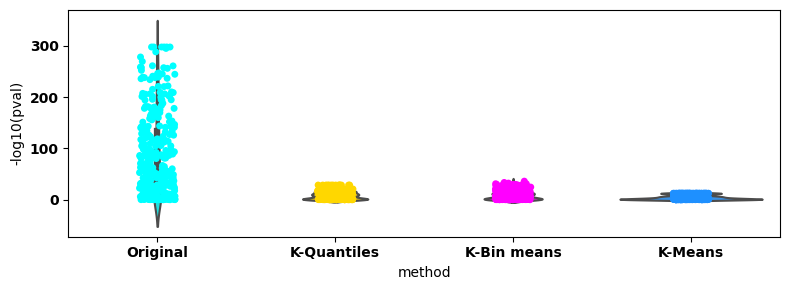

In [1278]:
method_colors1 = {'Original': 'cyan', 'K-Means': 'dodgerblue',
                'K-Bin means': 'magenta', 'K-Quantiles': 'gold'}

figsize = (8,3)
rot = 0
order = ['Original', 'K-Quantiles', 'K-Bin means', 'K-Means']
fig, ax = plt.subplots(figsize=figsize)
sb.violinplot(data=results, x='method', y='mean', ax=ax, order=order, palette=method_colors1)
sb.stripplot(data=results, x='method', y='mean', ax=ax, order=order, palette=method_colors1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=rot)
plt.show()

fig, ax = plt.subplots(figsize=figsize)
sb.violinplot(data=results, x='method', y='std', ax=ax, order=order, palette=method_colors1)
sb.stripplot(data=results, x='method', y='std', ax=ax, order=order, palette=method_colors1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=rot)
plt.show()

fig, ax = plt.subplots(figsize=figsize)
sb.violinplot(data=results, x='method', y='-log10(pval)', ax=ax, order=order, palette=method_colors1 )
sb.stripplot(data=results, x='method', y='-log10(pval)', ax=ax, order=order, palette=method_colors1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=rot)
plt.show()

## More importantly, should show how this effects the significance, does it simply move the significance downward? Or more complex? Make paired plots to exemplify this...

In [1226]:
def check_pvalue_changes(data: sc.AnnData, groupby: str, method: str, #EDIT
                               p_cut: float=None, orig_method: str='values',
                         show_legend: bool=True, legend_loc: str='best',
                         figsize: tuple=(6,4), point_size: int=3,
                         ax: matplotlib.axes.Axes=None, show: bool=True):
    """ Checks p-value changes across the results...

        Parameters
        ----------
        data: AnnData
            Single cell data on which cc.tl.merge_clusters has been performed.
        groupby: str
            Column in data.obs specifying pre-merged clusters input
                                                        to cc.tl.merge_clusters.
        p_cut: float
           P-value used as cutoff to determine significantly different clusters.
           If None then just shows the relationship without highlighting the
           significant versus non-significant cluster pairs.
        show_legend: bool
            Whether to show the legend that highlights significant versus non-
            significant cluster pairs.
        show: bool
            Whether to show the plot.
    """

    labels = data.obs[groupby].values.astype(str)
    label_set = np.unique(labels)

    cell_counts = np.array(
        [len(np.where(labels == label)[0]) for label in label_set])

    #### Getting the pairs which were compared
    pvals = np.array(list(data.uns[f'{groupby}_{method}_ps'].values()))
    min_sig_nonzero = min(pvals[pvals > 0])
    log10_ps = np.array(
        [-np.log10(pval + sys.float_info.min) for pval in pvals])
    log10_ps[pvals == 0] = -np.log10(min_sig_nonzero)
    pairs = np.array(list(data.uns[f'{groupby}_{method}_ps'].keys()))
    pair1s = np.array([pair.split('_')[-1] for pair in pairs])
    pair2s = np.array([pair.split('_')[0] for pair in pairs])
    
    ### Getting original values
    pvals_dict_orig = data.uns[f'{groupby}_{orig_method}_ps']
    pvals_orig = np.array([pvals_dict_orig[pair] for pair in pairs])
    min_sig_nonzero_orig = min(pvals_orig[pvals_orig > 0])
    log10_ps_orig = np.array(
            [-np.log10(pval + sys.float_info.min) for pval in pvals_orig])
    log10_ps_orig[pvals_orig == 0] = -np.log10(min_sig_nonzero_orig)

    corr = round(spearmanr(log10_ps_orig, log10_ps)[0], 3)

    if type(ax)==type(None):
        fig, ax = plt.subplots(figsize=figsize)
        
    if type(p_cut) != type(None):
        sig_bool_all = np.logical_and(pvals < p_cut, pvals_orig < p_cut)
        sig_bool_orig = np.logical_and(pvals >= p_cut, pvals_orig < p_cut)
        sig_bool_method = np.logical_and(pvals < p_cut, pvals_orig >= p_cut)
        nonsig_bool = np.logical_and(pvals >= p_cut, pvals_orig >= p_cut)

        ax.scatter(log10_ps_orig[sig_bool_all], log10_ps[sig_bool_all], 
                   s=point_size, c='dodgerblue')
        ax.scatter(log10_ps_orig[sig_bool_orig], log10_ps[sig_bool_orig], s=point_size,
                   c='magenta')
        ax.scatter(log10_ps_orig[sig_bool_method], log10_ps[sig_bool_method], s=point_size,
                   c='springgreen')
        ax.scatter(log10_ps_orig[nonsig_bool], log10_ps[nonsig_bool],
                   s=point_size, c='red')
        
        ax.hlines(-np.log10(p_cut), ax.get_xlim()[0], ax.get_xlim()[1],
                                                                   colors='red')

        legend = [f'Significant pairs all ({sum(sig_bool_all)})',
                  f'Non-significant pairs {method} ({sum(sig_bool_orig)})',
                  f'Non-significant pairs {orig_method} ({sum(sig_bool_method)})',
                  f'Non-significant pairs ({sum(nonsig_bool)})']

    else:
        ax.scatter(log10_ps_orig, log10_ps, s=point_size, c='orchid')

        legend = [f'Cluster pairs ({len(log_counts)})']

    ax.set_xlabel(f"{method} -log10(p-value)")
    ax.set_ylabel(f"{orig_method} -log10(p-value)")
    ax.set_title(f"Significance change due to {method}")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if show_legend:
        ax.legend(legend, loc=legend_loc)

    ax.text((ax.get_xlim()[0] + np.min(log10_ps_orig)) / 2, np.max(log10_ps),
            f'ρ: {corr}', c='k')

    if show:
        plt.show()

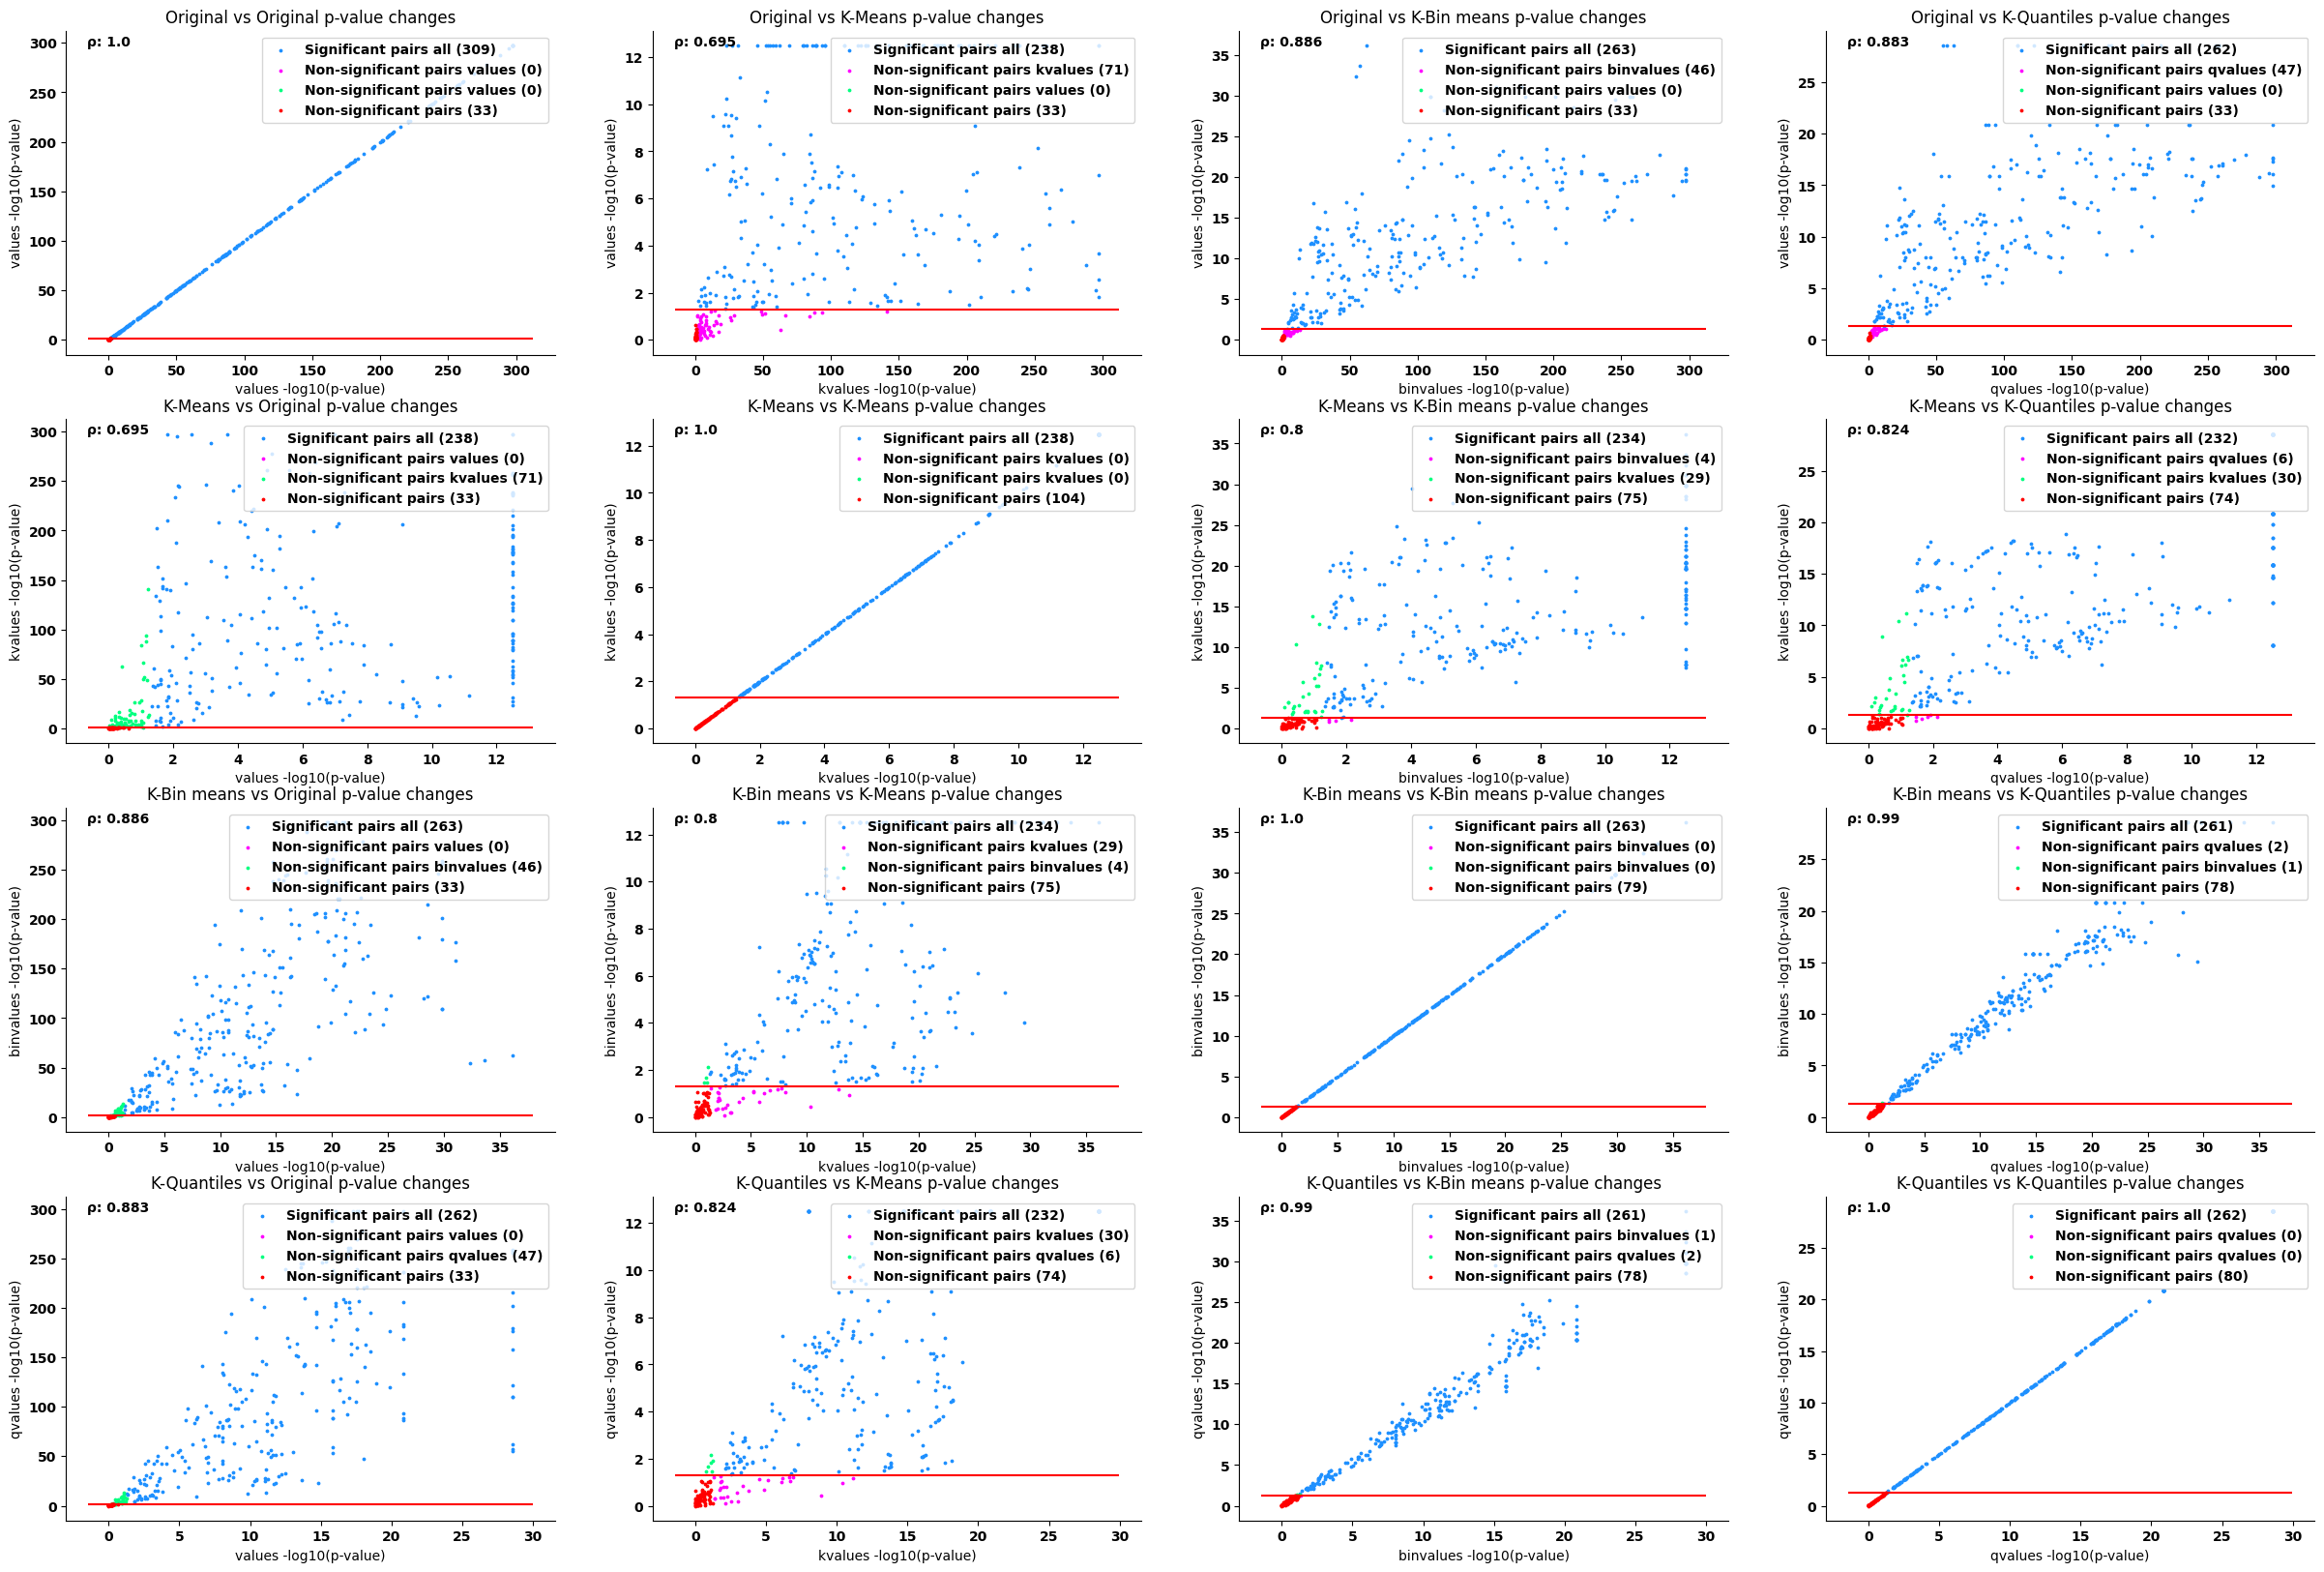

In [1227]:
fig, axes = plt.subplots(figsize=(30, 20), ncols=4, nrows=4)
method_names = ['Original', 'K-Means', 'K-Bin means', 'K-Quantiles']
for i, method in enumerate(methods):
    for j, methodj in enumerate(methods):
        check_pvalue_changes(data, 'leiden_col', methodj, p_cut=.05, ax=axes[i,j], orig_method=method,
                         show_legend=True, show=False, legend_loc='upper right')
        axes[i,j].set_title(f"{method_names[i]} vs {method_names[j]} p-value changes")
plt.show()

In [1349]:
merge_clusters(data, col, n_cpus=1)
update_method_ps(data, col, methods)

Initial merge.
0_1 344 22 15
344 3 16 15
0_2 344 22 15
344 4 16 15
0_3 344 22 15
344 15 16 15
0_4 344 22 15
344 15 16 15
0_5 344 22 15
344 10 16 15
0_6 344 22 15
344 2 16 15
0_7 344 22 15
344 1 16 15
0_8 344 22 15
344 1 16 15
0_9 344 22 15
344 15 16 15
0_10 344 22 15
344 15 16 15
0_11 344 22 15
344 15 16 15
0_12 344 22 15
344 15 16 15
0_13 344 22 15
344 15 16 15
0_14 344 22 15
344 15 16 15
0_15 344 22 15
344 15 16 15
0_16 344 22 15
344 10 16 15
0_17 344 22 15
344 15 16 15
0_18 344 22 15
344 2 16 15
1_0 312 20 15
312 15 16 15
1_2 312 20 15
312 1 16 15
1_3 312 20 15
312 15 16 15
1_4 312 20 15
312 15 16 15
1_5 312 20 15
312 15 16 15
1_6 312 20 15
312 15 16 15
1_7 312 20 15
312 2 16 15
1_8 312 20 15
312 1 16 15
1_9 312 20 15
312 15 16 15
1_10 312 20 15
312 14 16 15
1_11 312 20 15
312 15 16 15
1_12 312 20 15
312 15 16 15
1_13 312 20 15
312 15 16 15
1_14 312 20 15
312 15 16 15
1_15 312 20 15
312 15 16 15
1_16 312 20 15
312 8 16 15
1_17 312 20 15
312 15 16 15
1_18 312 20 15
312 4 16 15
2_0 20

17_9 36 2 15
36 15 18 15
17_10 36 2 15
36 8 18 15
17_11 36 2 15
36 15 18 15
17_12 36 2 15
36 15 18 15
17_13 36 2 15
36 15 18 15
17_14 36 2 15
36 15 18 15
17_15 36 2 15
36 15 18 15
17_16 36 2 15
36 2 18 15
17_18 36 2 15
36 1 18 15
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
12 12 12 12
Added data.obs['leiden_col_merged']
Exiting due to reaching max_iter 0


In [1350]:
##### Will use the results from merging with the main method as the ground truth.
# NOTE: get_merge_pairs defined below! so need to run cell below to get this to work!
method_for_truth, pcut = 'binvalues', 1e-3
get_merge_pairs(groupby, method_for_truth, pcut)

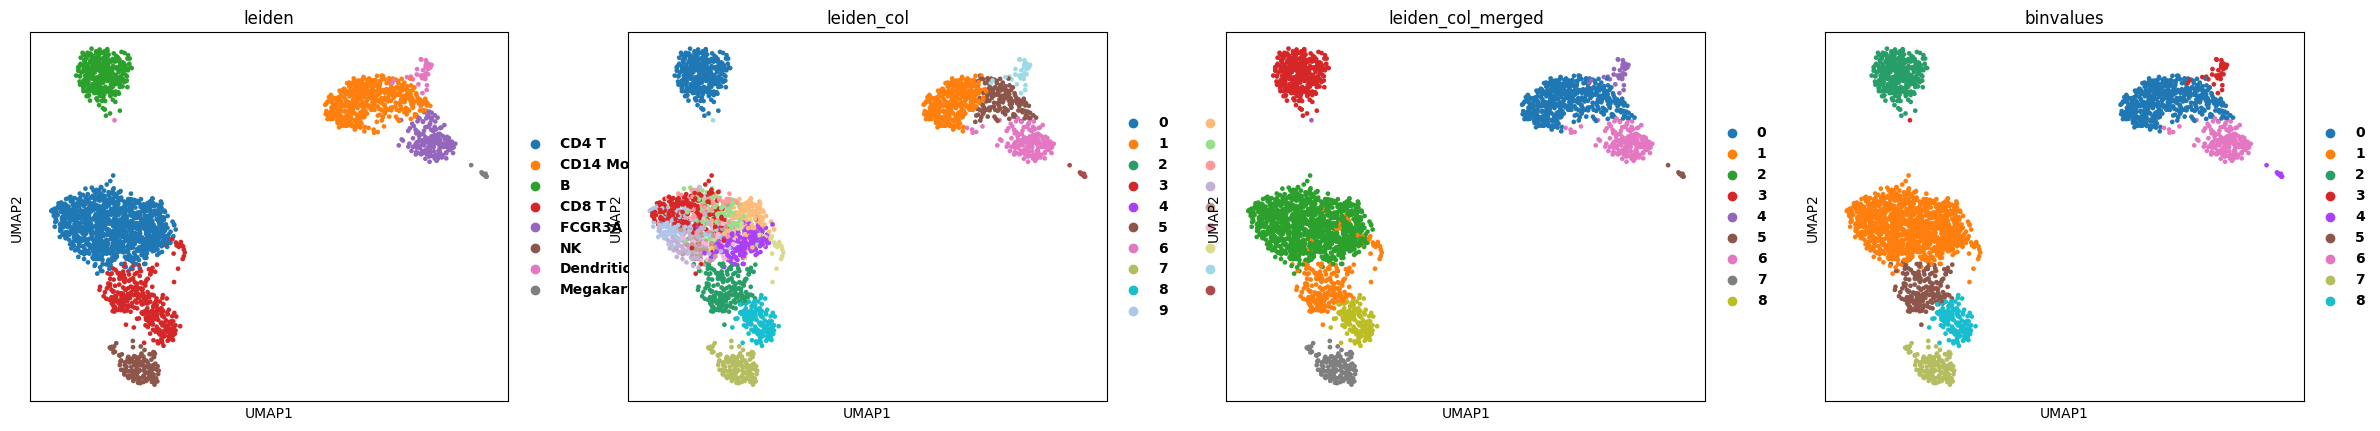

In [1351]:
sc.pl.umap(data, color=['leiden', 'leiden_col', 'leiden_col_merged', method_for_truth])

In [1352]:
print(np.all( np.array(list(data.uns['leiden_col_ps'].values())) == 
              np.array(list(data.uns['leiden_col_kvalues_ps'].values()))
            )
     )
print(np.all( np.array(list(data.uns['leiden_col_ps'].keys())) == 
              np.array(list(data.uns['leiden_col_kvalues_ps'].keys()))
            )
     )

True
True


In [1353]:
##### Let's get true versus false pairs based on pairs which belong to same higher cluster...
groupby = 'leiden_col'
method='kvalues'
pairs = np.array(list(data.uns[f'{groupby}_{method}_ps'].keys()))
ps = np.array(list(data.uns[f'{groupby}_{method}_ps'].values()))
pair_labels = []
pair_labels_k = (ps < .1).astype(int)
pair_new_label = []

current_labels = data.obs[groupby].values.astype(str)
# Ground truth labels; clusters which mutually fall within one of these clusters should not be different.
ground_truth = data.obs['leiden'].values.astype(str)
for pair in pairs:
    pair1, pair2 = pair.split('_')
    
    pair1_otherlabels = np.unique(ground_truth[current_labels==pair1])
    pair1_truth = pair1_otherlabels[np.argmax([sum(ground_truth[current_labels==pair1]==label)
                                   for label in pair1_otherlabels])]
    pair2_otherlabels = np.unique(ground_truth[current_labels==pair2])
    pair2_truth = pair2_otherlabels[np.argmax([sum(ground_truth[current_labels==pair2]==label)
                                   for label in pair2_otherlabels])]
        
    if np.all(pair1_truth==pair2_truth):
        pair_labels.append( 1 )
        pair_new_label.append(pair1_truth)

    else:
        pair_labels.append( 0 )
        pair_new_label.append('other')

pair_new_label = np.array(pair_new_label)
pair_labels = np.array( pair_labels )

In [1354]:
pairs[np.where(pair_labels!=pair_labels_k)[0]]

array(['0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8', '0_9',
       '0_10', '0_11', '0_13', '0_14', '0_16', '0_17', '0_18', '1_0',
       '1_2', '1_3', '1_4', '1_5', '1_6', '1_7', '1_8', '1_9', '1_10',
       '1_11', '1_12', '1_13', '1_14', '1_15', '1_16', '1_17', '1_18',
       '2_0', '2_1', '2_3', '2_5', '2_6', '2_7', '2_9', '2_10', '2_11',
       '2_12', '2_13', '2_15', '2_17', '2_18', '3_0', '3_1', '3_2', '3_4',
       '3_5', '3_6', '3_7', '3_8', '3_9', '3_10', '3_11', '3_12', '3_13',
       '3_14', '3_15', '3_16', '3_17', '3_18', '4_0', '4_1', '4_2', '4_3',
       '4_5', '4_6', '4_7', '4_8', '4_10', '4_11', '4_12', '4_14', '4_15',
       '4_16', '4_17', '4_18', '5_0', '5_1', '5_2', '5_3', '5_4', '5_6',
       '5_7', '5_8', '5_9', '5_10', '5_11', '5_12', '5_13', '5_14',
       '5_15', '5_16', '5_17', '5_18', '6_0', '6_1', '6_2', '6_3', '6_4',
       '6_5', '6_7', '6_8', '6_9', '6_10', '6_11', '6_12', '6_13', '6_14',
       '6_15', '6_16', '6_17', '6_18', '7_0', '7_1', '7_3

In [1355]:
pair = '2_4'
pair_new_label[pairs==pair]

array(['other'], dtype='<U14')

In [1356]:
print(pair_labels[pairs==pair])
print(pair_labels_k[pairs==pair])

[0]
[0]


In [1357]:
pair = '1_5'
print(pairs[pairs==pair])
print(pair_labels[pairs==pair])

['1_5']
[1]


In [1358]:
len(pair_labels)

342

In [1359]:
methods

['values', 'kvalues', 'binvalues', 'qvalues']

In [1360]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

method_colors = {'values': 'cyan', 'kvalues': 'dodgerblue',
                'binvalues': 'magenta', 'qvalues': 'gold'}

In [1124]:
?roc_curve

In [1362]:
res = 1000
p_cuts = np.array(list(range(0,res)))/res
p_cuts = p_cuts
p_cuts

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
       0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
       0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
       0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
       0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
       0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
       0.099, 0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107,
       0.108, 0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116,
       0.117, 0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125,
       0.126, 0.127,

In [1363]:
##### Logging to try and get a better range...
res = 100
p_cuts = np.array([2**(-i) for i in range(res)]+[0])[::-1]
p_cuts = p_cuts
p_cuts

array([0.00000000e+00, 1.57772181e-30, 3.15544362e-30, 6.31088724e-30,
       1.26217745e-29, 2.52435490e-29, 5.04870979e-29, 1.00974196e-28,
       2.01948392e-28, 4.03896783e-28, 8.07793567e-28, 1.61558713e-27,
       3.23117427e-27, 6.46234854e-27, 1.29246971e-26, 2.58493941e-26,
       5.16987883e-26, 1.03397577e-25, 2.06795153e-25, 4.13590306e-25,
       8.27180613e-25, 1.65436123e-24, 3.30872245e-24, 6.61744490e-24,
       1.32348898e-23, 2.64697796e-23, 5.29395592e-23, 1.05879118e-22,
       2.11758237e-22, 4.23516474e-22, 8.47032947e-22, 1.69406589e-21,
       3.38813179e-21, 6.77626358e-21, 1.35525272e-20, 2.71050543e-20,
       5.42101086e-20, 1.08420217e-19, 2.16840434e-19, 4.33680869e-19,
       8.67361738e-19, 1.73472348e-18, 3.46944695e-18, 6.93889390e-18,
       1.38777878e-17, 2.77555756e-17, 5.55111512e-17, 1.11022302e-16,
       2.22044605e-16, 4.44089210e-16, 8.88178420e-16, 1.77635684e-15,
       3.55271368e-15, 7.10542736e-15, 1.42108547e-14, 2.84217094e-14,
      

In [1364]:
from statsmodels.stats.multitest import multipletests

##### Which method gets ground-truth best???
method_labels = []
adjust = False

method_fprs = {}
method_tprs = {}
method_aucs = {}

for j, method in enumerate(methods):

    # Get p-values
    pvals = np.array([data.uns[f'{groupby}_{method}_ps'][pair] for pair in pairs])
    if adjust:
        pvals = multipletests(pvals, method='fdr_bh')[1]
    #min_sig_nonzero = min(pvals[pvals > 0])
    #log10_ps = np.array(
    #    [-np.log10(pval + sys.float_info.min) for pval in pvals])
    #log10_ps[pvals == 0] = -np.log10(min_sig_nonzero)
        
    # Compute ROC curve and ROC area for each class
    n_nonsig, n_sig = sum(pair_labels==1), sum(pair_labels==0)
    fpr, tpr = np.zeros((len(p_cuts))), np.zeros((len(p_cuts)))
    for pi, p_cut_ in enumerate(p_cuts):
        nonsig_bool = pvals >= p_cut_
        
        tp = sum(np.logical_and(nonsig_bool, pair_labels==1))
        tpr[pi] = tp / n_nonsig
        
        fp = sum(np.logical_and(nonsig_bool, pair_labels==0))
        #print(p_cut, fp)
        fpr[pi] = fp / n_sig
    
    #print(thresholds)
    roc_auc = auc(fpr, tpr)
    
    method_fprs[method] = fpr
    method_tprs[method] = tpr
    method_aucs[method] = roc_auc
    
    print(method, roc_auc)

values 0.9812328414550446
kvalues 0.9516129032258065
binvalues 0.9780585106382979
qvalues 0.9803320178448868


In [1365]:
print(p_cuts[0:20])
print('\n')
method = 'values'
print( method_tprs[method][0:20] )
print( method_fprs[method][0:20] )
print('\n')
method = 'kvalues'
print( method_tprs[method][0:20] )
print( method_fprs[method][0:20] )

[0.00000000e+00 1.57772181e-30 3.15544362e-30 6.31088724e-30
 1.26217745e-29 2.52435490e-29 5.04870979e-29 1.00974196e-28
 2.01948392e-28 4.03896783e-28 8.07793567e-28 1.61558713e-27
 3.23117427e-27 6.46234854e-27 1.29246971e-26 2.58493941e-26
 5.16987883e-26 1.03397577e-25 2.06795153e-25 4.13590306e-25]


[1.        0.9893617 0.9893617 0.9893617 0.9893617 0.9893617 0.9893617
 0.9893617 0.9893617 0.9893617 0.9893617 0.9893617 0.9893617 0.9893617
 0.9787234 0.9787234 0.9787234 0.9787234 0.9787234 0.9787234]
[1.         0.16935484 0.16935484 0.16532258 0.16532258 0.16129032
 0.15725806 0.15322581 0.14919355 0.14516129 0.14112903 0.14112903
 0.12903226 0.125      0.11693548 0.11693548 0.11290323 0.10887097
 0.10887097 0.10483871]


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.         0.75806452 0.75806452 0.75806452 0.75806452 0.75806452
 0.75806452 0.75806452 0.75806452 0.75806452 0.75806452 0.75806452
 0.75806452 0.75806452 0.75806452 0.75806452 0.75806452 0.7580645

In [1366]:
out_plots

'plots/coexpr_score/diagnostics/'

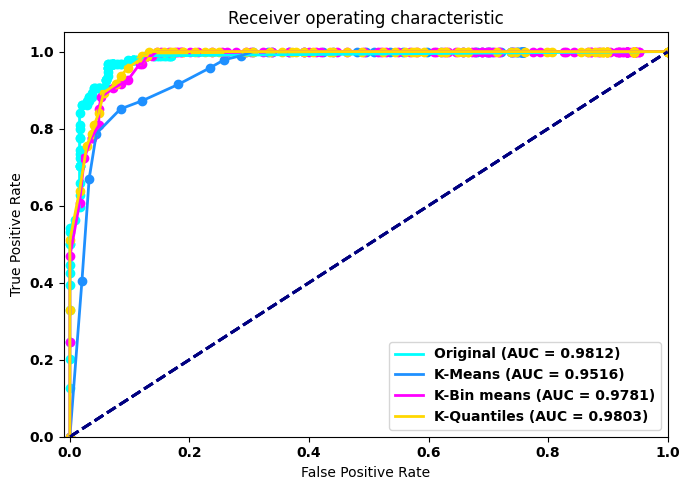

In [1367]:
methods_ = ['values', 'kvalues']
methods_ = ['values', 'qvalues']
plt.figure(figsize=(7,5))
for j, method in enumerate(methods):
    fpr = method_fprs[method]
    tpr = method_tprs[method]
    roc_auc = method_aucs[method]

    lw = 2
    plt.plot(
        fpr,
        tpr,
        color=method_colors[method],
        lw=lw,
        label=f"{method_names[j]} (AUC = %0.4f)" % roc_auc,
    )
    plt.scatter(fpr, tpr, color=method_colors[method],)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
plt.show()

In [1153]:
###### Optimal p-value cutoff for each method based on point with the highest TPR for FPR ratio;
###### i.e. positive likelihood ratio
method_pcuts = {}
for method in methods:
    tpr = method_tprs[method]
    fpr = method_fprs[method]
    
    keep_bool = np.logical_and(tpr < 1, tpr > 0)
    keep_bool = np.logical_and(keep_bool, fpr > 0)
    tpr, fpr = tpr[keep_bool], fpr[keep_bool]
    
    plrs = tpr / fpr
    print(plrs)

[  8.36977256   8.66869301   8.98975571   9.33551555   9.33551555
   9.33551555   9.33551555   9.33551555  10.11347518  10.11347518
  10.43848289  10.43848289  11.43262411  11.43262411  12.00425532
  13.33806147  13.33806147  13.33806147  13.33806147  13.33806147
  13.33806147  13.33806147  13.33806147  14.12265332  14.12265332
  14.12265332  14.12265332  15.00531915  15.00531915  14.84042553
  14.84042553  14.84042553  14.84042553  14.5106383   14.34574468
  15.30212766  15.30212766  15.30212766  15.12624113  14.95035461
  16.01823708  17.25040917  17.25040917  18.68794326  18.68794326
  18.68794326  20.3868472   22.42553191  22.16170213  24.62411348
  27.37234043  27.37234043  27.04255319  27.04255319  30.52887538
  42.74042553  42.74042553  42.74042553  50.78723404  50.12765957
  48.14893617  48.14893617  46.17021277  46.17021277  44.85106383
  43.53191489  43.53191489  43.53191489  43.53191489  40.89361702
  39.57446809  37.59574468  46.60992908 139.82978723]
[ 3.50516717  3.914893

In [1154]:
from statsmodels.stats.multitest import multipletests
?multipletests

In [1244]:
from statsmodels.stats.multitest import multipletests

def get_merge_pairs(groupby, method, p_cut, adjust=False): 
    """Determines pairs to merge based on p-value dictionary"""
    merge_pairs = []

    pvals_dict = data.uns[f'{groupby}_{method}_ps']
    pvals = np.array( list( pvals_dict.values() ) )
    if adjust:
        pvals = multipletests(pvals, method='fdr_bh')[1]
    pairs = np.array( list( pvals_dict.keys() ) )
    nonsig_pairs = pairs[pvals>=p_cut]

    nonsig_pairs = [tuple(pair.split('_')) for pair in nonsig_pairs]

    for pairi in nonsig_pairs:
        for pairj in nonsig_pairs:
            if pairi[0] == pairj[1] and pairi[1] == pairj[0] \
                    and pairi not in merge_pairs and pairj not in merge_pairs:
                merge_pairs.append(pairi)

    #### Now merging..
    labels = data.obs[groupby].values.astype(str)
    cluster_map, merge_cluster_labels = cm.merge_neighbours_v2(labels, merge_pairs)

    data.obs[method] = merge_cluster_labels
    data.obs[method] = data.obs[method].astype('category')

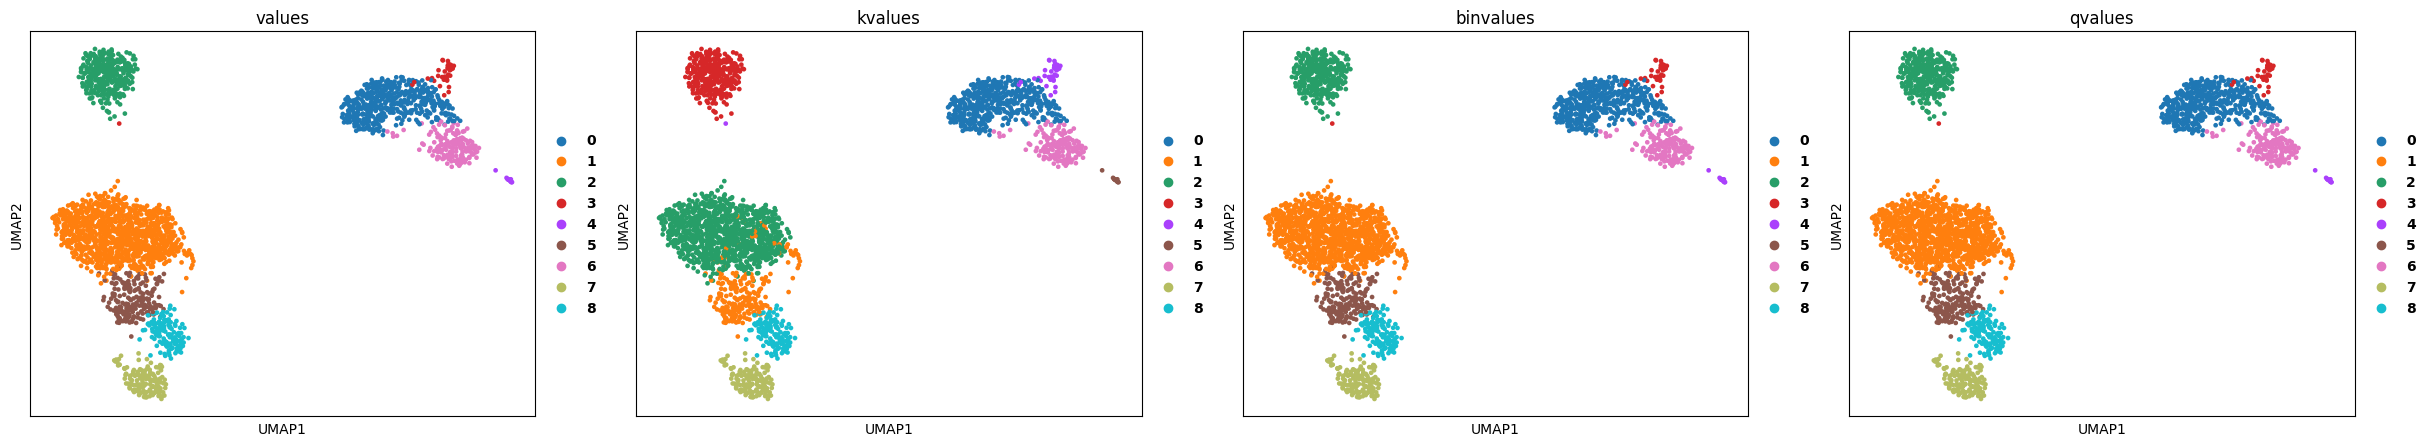

In [1245]:
fig, axes = plt.subplots(ncols=4, figsize=(30,5))
axes = axes.ravel()
method_pcuts = [1e-18, .1, 1e-3, 1e-2] # For some reason, one of the clusters switches depending on cutoff...
for i, method in enumerate(methods):
    get_merge_pairs(groupby, method, method_pcuts[i])
    sc.pl.umap(data, color=method, ax=axes[i], show=False)
plt.show()

Based on the above, it looks like can reproduce pretty much the same results with all of the different methods, even without calling the different p-values, albeit there is a slightly different decision with the KMeans. 

Think that, since currently do not perform multiple hypothesis testing (MHT) adjustment, using the other methods with MHT will probably produce more reasonable p-values...

So I'm feeling that that is a better option, can add these bench-marking data to the results as well. 

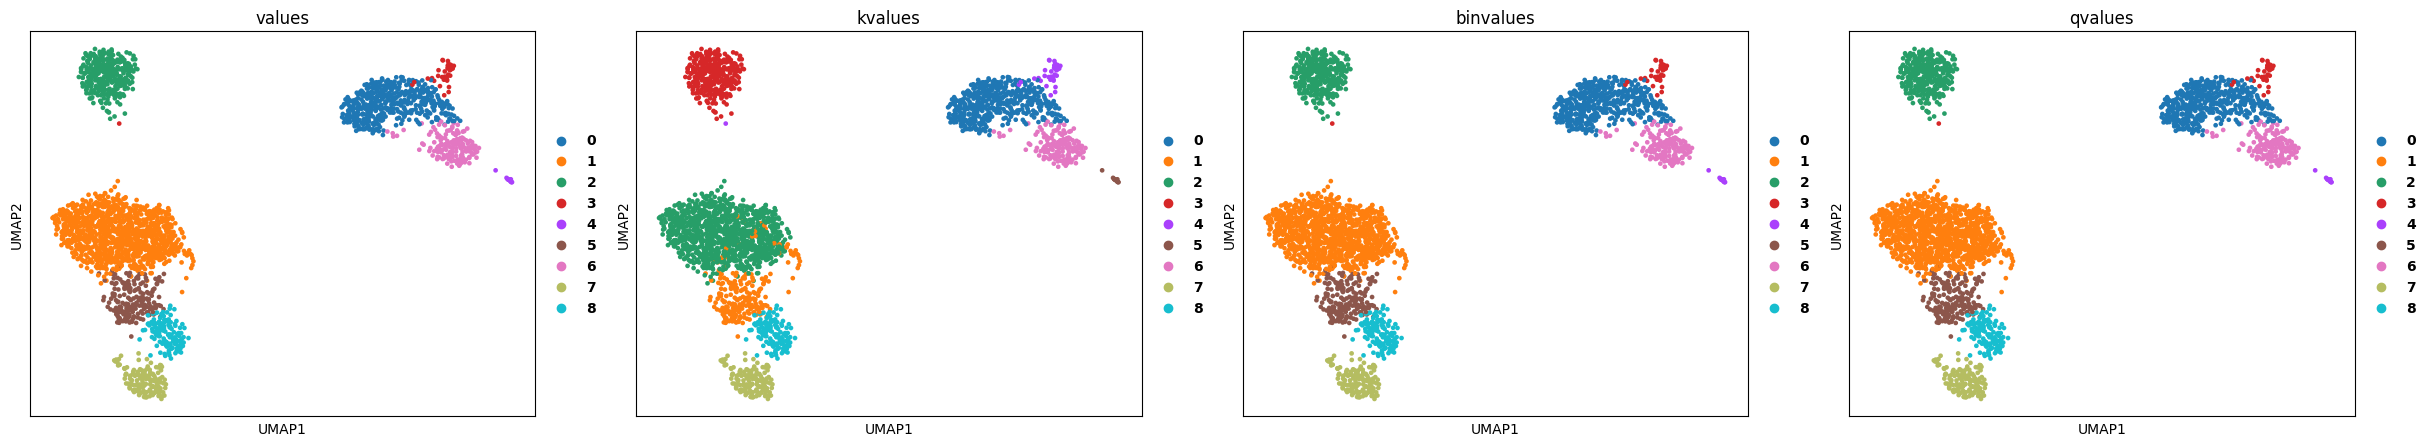

In [1246]:
##### What happens if we adjust the p-values???
fig, axes = plt.subplots(ncols=4, figsize=(30,5))
axes = axes.ravel()
method_pcuts = [1e-18, .2, 1e-2, 1e-2] # For some reason, one of the clusters switches depending on cutoff...
for i, method in enumerate(methods):
    get_merge_pairs(groupby, method, method_pcuts[i], adjust=True)
    sc.pl.umap(data, color=method, ax=axes[i], show=False)
plt.show()

In [1008]:
k=15
q = np.array([(1 / k) * i for i in range(1, k + 1)])
q

array([0.06666667, 0.13333333, 0.2       , 0.26666667, 0.33333333,
       0.4       , 0.46666667, 0.53333333, 0.6       , 0.66666667,
       0.73333333, 0.8       , 0.86666667, 0.93333333, 1.        ])

# K sensitivity analysis

In [1279]:
?merge_clusters

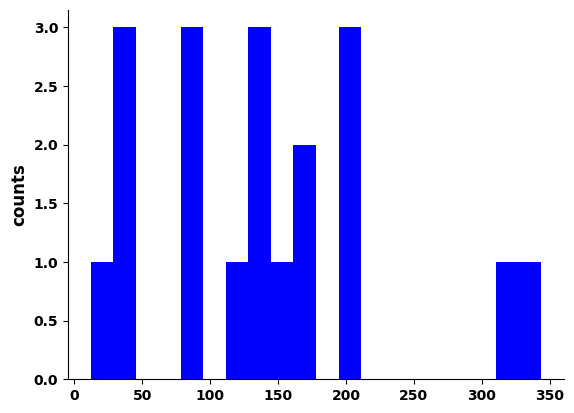

[344 312]
344
656
21
[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 30, 80, 130, 180, 230, 280, 330, None]


In [1281]:
##### Performing the sensitivity analysis for K with respect to the quantiles method.
method = 'qvalues'

## Checking max cluster pair size...
groupby = col
labels = data.obs[groupby].values.astype(str)
label_set = np.unique(labels)

cell_counts = np.array(
    [len(np.where(labels == label)[0]) for label in label_set])
qpl.distrib(cell_counts, bins=20)

order = np.argsort(-cell_counts)
max_size = max(cell_counts)
max_pair_size = sum(cell_counts[order[0:2]])
print(cell_counts[order[0:2]])
print(max_size)
print(max_pair_size)

ks = list(range(5, 30, 2))+list(range(30, max_size, 50))+[None]
print(len(ks))
print(ks)

In [1369]:
methods

['values', 'kvalues', 'binvalues', 'qvalues']

In [1370]:
##### For each pair, calculate the p-value with the different methods...
def update_method_ps(data, groupby, methods):
    pairs = list( data.uns[f'{groupby}_ps'].keys() )
    method_ps = [{} for method in methods]

    for i, method in enumerate(methods):
        for pair in pairs:
            t, p = ttest_ind(data.uns[f'leiden_col_{method}'][pair][0], 
                             data.uns[f'leiden_col_{method}'][pair][1])
            p = p if not np.isnan(p) else 0

            method_ps[i][pair] = p

        data.uns[f'{groupby}_{method}_ps'] = method_ps[i]

In [ ]:
#### For PBMC data!
from scipy.stats import spearmanr

method_spearmans = {method: [] for method in methods}
method_aucs = {method: [] for method in methods}

for i, k in enumerate(ks):
    #### Merging clusters
    print('Current k: ', k)
    merge_clusters(data, col, n_cpus=1, k=k)
    update_method_ps(data, col, methods)
    
    for method in methods:
        #### Gettings the p-value stats
        pvals = np.array(list(data.uns[f'{col}_{method}_ps'].values()))
        min_sig_nonzero = min(pvals[pvals > 0])
        log10_ps = np.array(
            [-np.log10(pval + sys.float_info.min) for pval in pvals])
        log10_ps[pvals == 0] = -np.log10(min_sig_nonzero)
        pairs = np.array(list(data.uns[f'{col}_{method}_ps'].keys()))
        pair1s = np.array([pair.split('_')[-1] for pair in pairs])
        pair2s = np.array([pair.split('_')[0] for pair in pairs])

        #### Calculating correlation with total spots in cluster pair.
        log_counts = np.array(
            [np.log2(np.sum([cell_counts[label_set == pair1s[i]][0],
                             cell_counts[label_set == pair2s[i]][0]]))
             for i in range(len(pairs))])

        corr = round(spearmanr(log_counts, log10_ps)[0], 3)

        method_spearmans[method].append( corr )

        #### Calculating the AUC for the ROC curve
        n_nonsig, n_sig = sum(pair_labels==1), sum(pair_labels==0)
        fpr, tpr = np.zeros((len(p_cuts))), np.zeros((len(p_cuts)))
        for pi, p_cut_ in enumerate(p_cuts):
            nonsig_bool = pvals >= p_cut_

            tp = sum(np.logical_and(nonsig_bool, pair_labels==1))
            tpr[pi] = tp / n_nonsig

            fp = sum(np.logical_and(nonsig_bool, pair_labels==0))
            fpr[pi] = fp / n_sig

        roc_auc = auc(fpr, tpr)
        method_aucs[method].append( roc_auc )
    
print("DONE!!!!!!")

In [1372]:
method_colors

{'values': 'cyan',
 'kvalues': 'dodgerblue',
 'binvalues': 'magenta',
 'qvalues': 'gold'}

In [1373]:
method_ro_avg = []
method_auc_avg = []
n_ks = len(method_aucs['values'])

for i in range(n_ks):
    spearmans = []
    aucs = []
    for method in methods:
        spearmans.append( method_spearmans[method][i] )
        aucs.append( method_aucs[method][i] )
    
    method_ro_avg.append( np.mean( spearmans ) )
    method_auc_avg.append( np.mean( aucs ) )
    
print(method_ro_avg)
print(method_auc_avg)

[0.1375, 0.13375, 0.14450000000000002, 0.15300000000000002, 0.14725, 0.15525, 0.162, 0.15925, 0.1595, 0.16675, 0.171, 0.17325, 0.17700000000000002, 0.17650000000000002, 0.269, 0.32325000000000004, 0.3705, 0.40625, 0.4155, 0.42924999999999996, 0.446]
[0.9636238846945778, 0.9681494509265614, 0.9712701612903226, 0.9717849176389842, 0.9738064087165409, 0.9728090682910089, 0.973817132807138, 0.9749806966369252, 0.9734203414550445, 0.9740369766643788, 0.9734417896362388, 0.973683081674674, 0.973270204186685, 0.9729270332875772, 0.9713184196980096, 0.9708358356211394, 0.9774043411118736, 0.9781067690459848, 0.9783158888126287, 0.9793293153740563, 0.9812328414550446]


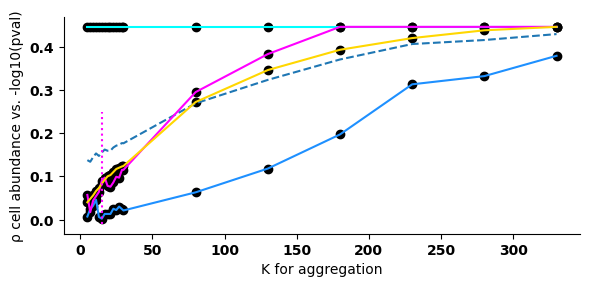

In [1379]:
##### Plotting the Spearman's as function of K
fig, ax = plt.subplots(figsize=(6,2.9))

n_ks = len(method_ro_avg)
ks_sub = ks[0:n_ks]

ax.plot(ks[0:n_ks], method_ro_avg, linestyle='--')
for method in methods:
    spearmans = method_spearmans[method]

    ax.scatter(ks_sub, spearmans, c='k')
    ax.plot(ks_sub, spearmans, c=method_colors[method])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#ax.set_title('Cell abundance bias corrected by KMeans prior to significance testing')
ax.set_xlabel("K for aggregation")
ax.set_ylabel("ρ cell abundance vs. -log10(pval)")
ax.vlines(15, -0.01, .25, colors='magenta', linestyles='dotted'
         )
plt.show()

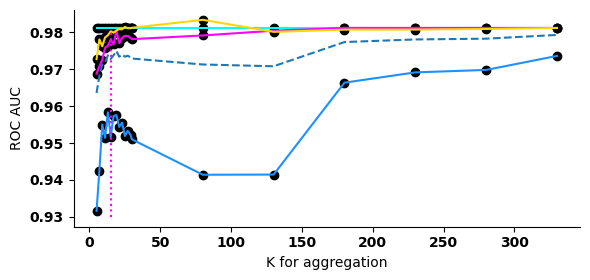

In [1380]:
##### Plotting the ROC AUC as function of K
fig, ax = plt.subplots(figsize=(6,2.9))

n_ks = len(method_ro_avg)
ks_sub = ks[0:n_ks]

ax.plot(ks[0:n_ks], method_auc_avg, linestyle='--')
for method in methods:
    aucs = method_aucs[method]

    ax.scatter(ks_sub, aucs, c='k')
    ax.plot(ks_sub, aucs, c=method_colors[method])

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#ax.set_title('Cell abundance bias corrected by KMeans prior to significance testing')
ax.set_xlabel("K for aggregation")
ax.set_ylabel("ROC AUC")
ax.vlines(15, .93, .98, colors='magenta', linestyles='dotted'
         )
plt.show()